# Predicting Customer Churn with Machine Learning 🏦💰

<img src="https://images.unsplash.com/photo-1520033906782-1684d0e7498e?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1334&q=80" width = 600>
<center><em>Photo by Michael Jasmund (Unsplash)</em></center>

<br>

**Table of Contents**

- [Introduction](#Introduction)
- [Objective](#Objective)
- [Libraries](#Libraries)
- [Default Parameters](#Default-Parameters)
- [Functions](#Functions)
- [A Quick Look at our Data](#A-Quick-Look-at-our-Data)
- [Creating a Test Set](#Creating-a-Test-Set)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Target Variable: Exited](#Target-Variable:-Exited)
    - [Continuous Variables](#Continuous-Variables)
    - [Categorical Variables](#Categorical-Variables)
- [Data Pre-processing](#Data-Pre-processing)
    - [Feature Selection](#Feature-Selection) <br>
    - [Encoding Categorical Features](#Encoding-Categorical-Features) <br>
    - [Scaling](#Scaling) <br>
    - [Addressing Class Imbalance](#Addressing-Class-Imbalance) <br>
    - [Pre-processing the Test Set](#Pre-processing-the-Test-Set)
- [Building Machine Learning Models](#Building-Machine-Learning-Models)
    - [Baseline Models](#Baseline-Models) <br>
    - [Model Tuning](#Model-Tuning) <br>
        - [Logistic Regression](#Logistic-Regression) <br>
        - [Support Vector Classifier](#Support-Vector-Classifier) <br>
        - [Random Forest](#Random-Forest) <br>
        - [Random Forest With Random Undersampling](#Random-Forest-With-Random-Undersampling) <br>
        - [Gradient Boosting Classifier](#Gradient-Boosting-Classifier) <br>
        - [XGBoost Classifier](#XGBoost-Classifier) <br>
        - [LGBMClassifier](#LGBMClassifier) <br>
        - [Ensemble Learning](#Ensemble-Learning) <br>
- [Results](#Results)
    - [Feature Importance](#Feature-Importance) <br>
    - [Performance Comparison](#Performance-Comparison) <br>
- [Evaluating the Test Set](#Evaluating-the-Test-Set)
- [Calculating Profit](#Calculating-Profit)
- [References](#References)
- [Conclusions](#Conclusions)

<br>

# Introduction

Customer churn (also known as customer attrition) occurs when a customer stops using a company's products or services. 

Customer churn affects profitability, especially in industries where revenues are heavily dependent on subscriptions (e.g. banks, telephone and internet service providers, pay-TV companies, insurance firms, etc.). It is estimated that acquiring a new customer can cost up to five times more than retaining an existing one.

Therefore, customer churn analysis is essential as it can help a business:

- Identify problems in its services (e.g. poor quality product/service, poor customer support, wrong target audience, etc.), and 
- Make correct strategic decisions that would lead to higher customer satisfaction and consequently higher customer retention.

If you want to know more about this topic, please refer to Refs. [[10-13]](#References).

<br>

# Objective

This notebook aims to understand and predict customer churn for a bank. Specifically, we will initially perform **Exploratory Data Analysis** (**EDA**) to identify and visualise the factors contributing to customer churn. This analysis will later help us **pre-process** our data and **build Machine Learning** (**ML**) models to predict whether a customer will churn or not.

This problem is a typical **binary classification** task. The predictive power of our models will be assessed based on the **area under the ROC curve** (**AUC**). The same metric will be used during hyperparameter tuning to find the optimal parameters for the ML models.

<br>

*Skills: Exploratory Data Analysis, Data Visualisation, Data Pre-processing (Feature Selection, Encoding Categorical Features, Feature Scaling), Addressing Class Imbalance, Model Tuning, Ensemble Learning.*

*Models Used: Logistic Regression, Support Vector Machines, Random Forests, Gradient Boosting, XGBoost, and Light Gradient Boosting Machine.*

<br>

# Libraries

In [1]:
# Data Handling and Analysis
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chi2_contingency

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

import scikitplot as skplt

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

<br>

# Default Parameters

In [2]:
pd.set_option('precision', 3)

%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

edgecolor = 'white'
facecolor = '#f0f0f0'

plt.rcParams['axes.edgecolor'] = '0.15'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.facecolor'] = facecolor

font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

random_state = 0

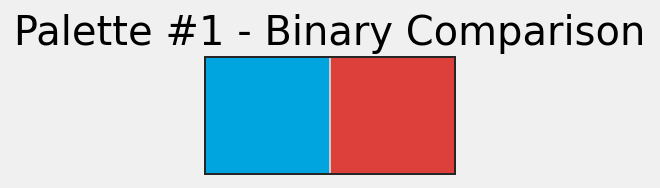

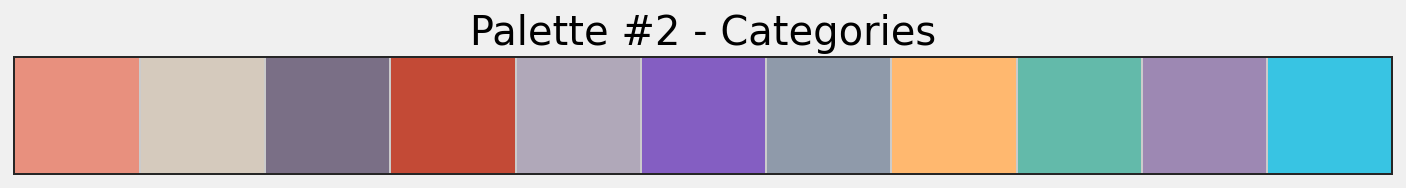

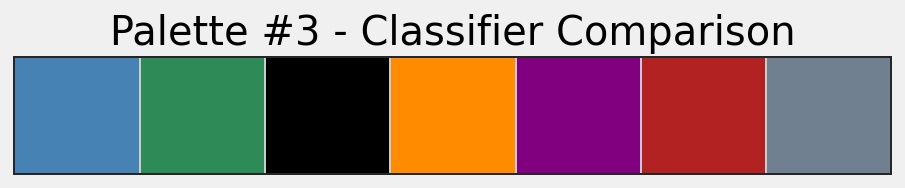

In [3]:
colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2',
              '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple',
               'firebrick', 'slategrey']

sns.palplot(colors)
plt.title('Palette #1 - Binary Comparison')
plt.tick_params(axis='x', bottom=False, labelbottom=False)

sns.palplot(colors_cat)
plt.title('Palette #2 - Categories')
plt.tick_params(axis='x', bottom=False, labelbottom=False)

sns.palplot(colors_comp)
plt.title('Palette #3 - Classifier Comparison')
plt.tick_params(axis='x', bottom=False, labelbottom=False)

<br>

# Functions

## `plot_continuous()`

In [4]:
def plot_continuous(df, feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_churned = df[df['Exited'] == 1]
    df_retained = df[df['Exited'] == 0]

    df_func = df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned],
                                colors,
                                ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor=edgecolor,
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature,
                y='Exited',
                data=df_func,
                linewidth=1.5,
                palette=colors,
                ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout()

<br>

## `plot_categorical()`

In [5]:
def plot_categorical(df, feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=df,
                  palette=colors,
                  ax=ax1)
    
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=df,
                palette=colors_cat, errwidth=2,
                ax=ax2)
    
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout()

<br>

## `plot_conf_mx()`

In [6]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': font_size + 10},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned'])

<br>

## `clf_performance()`

In [7]:
comparison_dict = {}

def clf_performance(classifier, classifier_name, classifier_name_abv, cv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=cv,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, ax = plt.subplots(figsize=(6, 5))

    plot_conf_mx(cm, ax)

<br>

# A Quick Look at our Data

We start by importing the dataset as a Pandas DataFrame. We can also take a look at the top five rows using the `head()` method:

In [8]:
df = pd.read_csv('Data\Dataset.csv')

print('Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
print('Top five rows:')
df.head()

Dataset Imported Successfully!

It contains 10000 rows and 14 columns.
Top five rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our DataFrame has 14 features and 10K instances. The last feature, '**Exited**', is the **target variable** and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

In [9]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

The `info()` method can give us valuable information such as the number of non-null values and the type of each feature:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Thankfully, there are **no missing values** in our DataFrame. The `describe()` method gives us a statistical summary of the numerical features:

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.529,96.653,350.00,584.00,652.000,718.000,850.00
Age,10000.0,38.922,10.488,18.00,32.00,37.000,44.000,92.00
Tenure,10000.0,5.013,2.892,0.00,3.00,5.000,7.000,10.00
Balance,10000.0,76485.889,62397.405,0.00,0.00,97198.540,127644.240,250898.09
NumOfProducts,10000.0,1.530,0.582,1.00,1.00,1.000,2.000,4.00
HasCrCard,10000.0,0.706,0.456,0.00,0.00,1.000,1.000,1.00
IsActiveMember,10000.0,0.515,0.500,0.00,0.00,1.000,1.000,1.00
EstimatedSalary,10000.0,100090.240,57510.493,11.58,51002.11,100193.915,149388.247,199992.48
Exited,10000.0,0.204,0.403,0.00,0.00,0.000,0.000,1.00


The most important things to note are:

- The age of customers ranges from 18 to 92, with a mean value approximately equal to 40.
- The mean (and median) tenure is five years, so the majority of customers are loyal (tenure > 3).
- Approximately 50% of customers are active.

EDA will help us understand our dataset better. However, before we look at the data further, we need to create a **test set**, put it aside, and use it only to evaluate our ML models. This practice protects our models from **data snooping bias** (you can read more on page 51 of Ref. [[1](#References)]) and ensures that evaluation will be performed using unseen data. 

<br>

# Creating a Test Set

We will split our dataset into a train and a test set using scikit-learn's `StratifiedShuffleSplit()` function, which implements **stratified sampling**. In this method, the population is divided into homogeneous subgroups called *strata*, and the right number of instances are sampled from each stratum to guaranτee that the test set is representative of the overall population (Ref. [[1](#References)]).

In [12]:
split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.2,
                               random_state=random_state)

for train_index, test_index in split.split(df, df['Exited']):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]

<br>

---

# Exploratory Data Analysis

## Target Variable: Exited

As we mentioned earlier, the target variable is already encoded and can take two possible values:

- Zero (0) for a customer that has **not** churned, and
- One (1) for a customer that has churned.

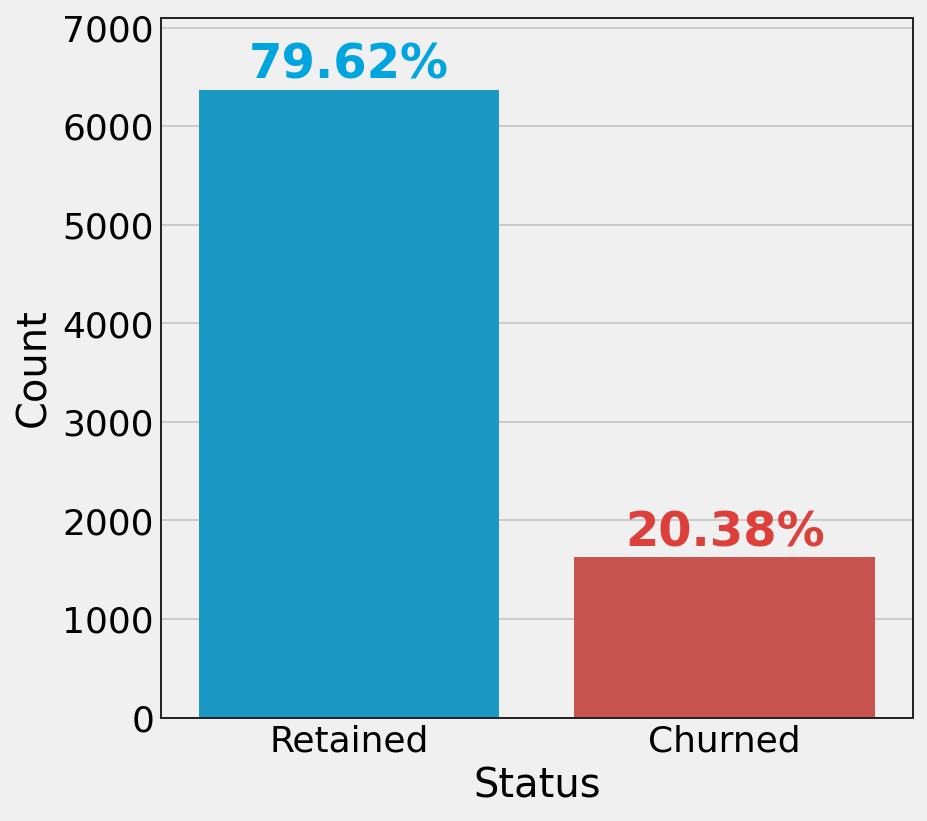

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 4)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set(xlabel='Status', ylabel='Count')
ax.set_ylim([0, 7100]);

The bank kept 80% of its clientele.

Notice that our dataset is **skewed/imbalanced** since the number of instances in the 'Retained' class outnumbers the number of instances in the 'Churned' class by a factor of 4. Therefore, we need to factor in class imbalance before building any models.

Different visualisation techniques apply to different types of variables, so it is helpful to differentiate between continuous and categorical variables and look at them separately.

In [14]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


<br>

## Continuous Variables

By calling the `hist()` method, we can plot a histogram for each of the four continuous numeric features:

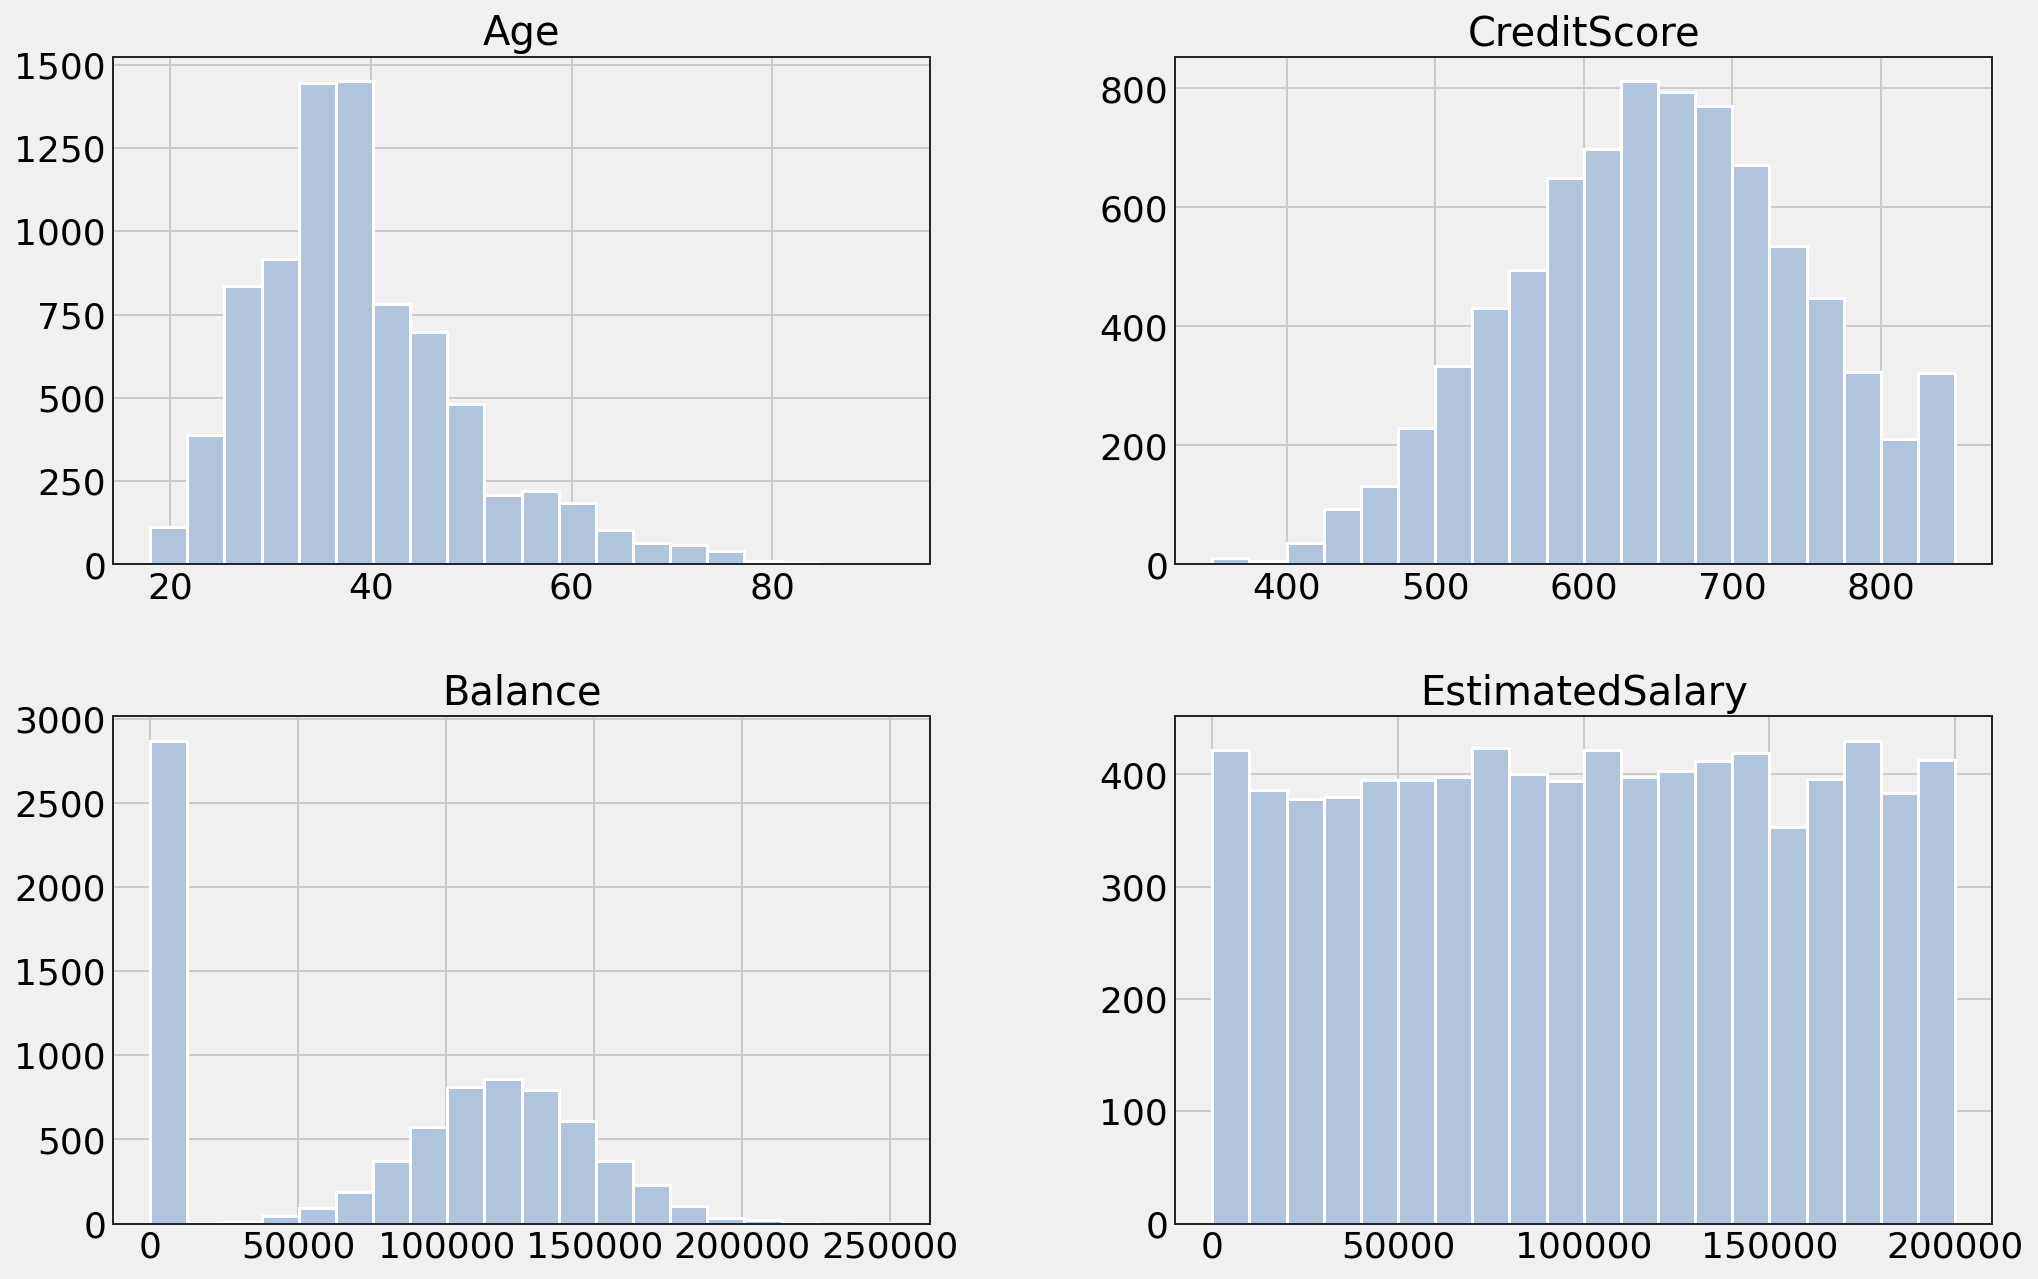

In [15]:
fig, ax = plt.subplots(figsize=(15, 10), facecolor=facecolor)

train_df[continuous].hist(bins=20,
                          layout=(2, 2),
                          color='lightsteelblue',
                          edgecolor=edgecolor,
                          linewidth=1.5,
                          ax=ax);

- 'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,
- Most values for 'CreditScore' are above 600,
- If we ignore the first bin, 'Balance' follows a relatively normal distribution, and
- The distribution of 'EstimatedSalary' is more or less uniform and provides little information.

<br>

### Looking for Correlations

We can compute the standard correlation coefficient between every pair of (continuous) features using the pandas' `corr()` method and plot it as a matrix:

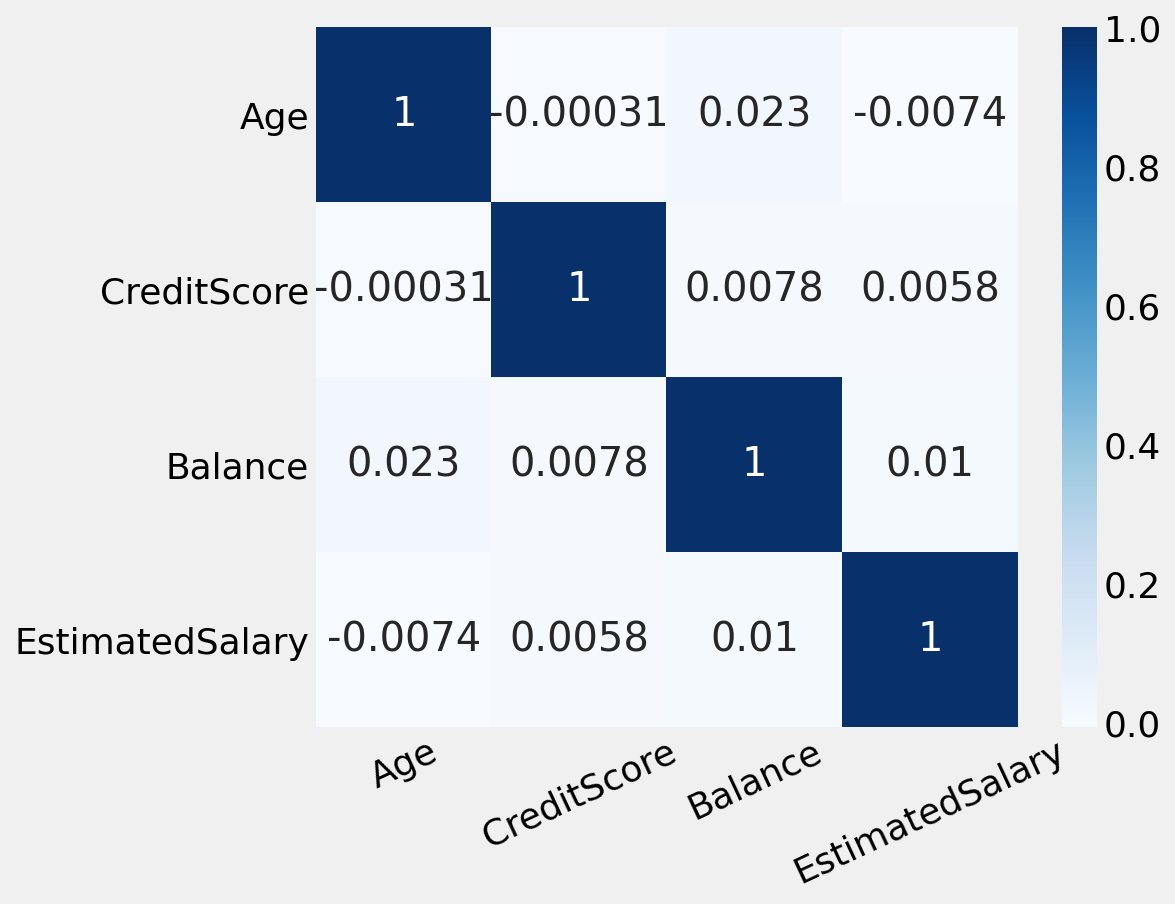

In [16]:
ig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': font_size},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=25)
ax.tick_params(axis='y', rotation=360);

There is no significant intercorrelation between our features, so we do **not** have to worry about multicollinearity.

Let's look at these features in greater detail.

<br>

### Age

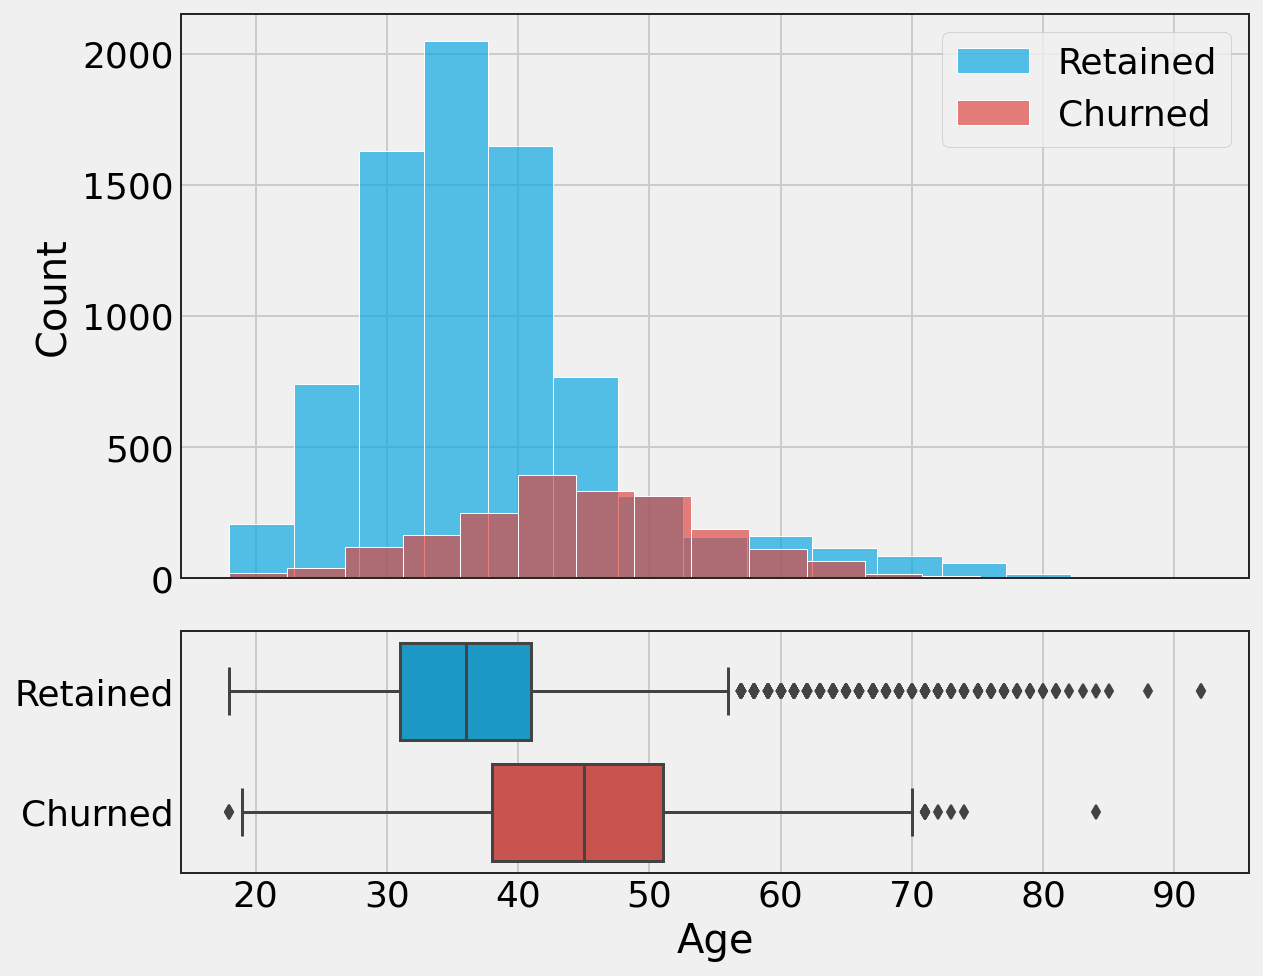

In [17]:
plot_continuous(df, 'Age')

Interestingly, there is a clear difference between age groups, with older customers more likely to churn. This observation could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

<br>

### Credit Score

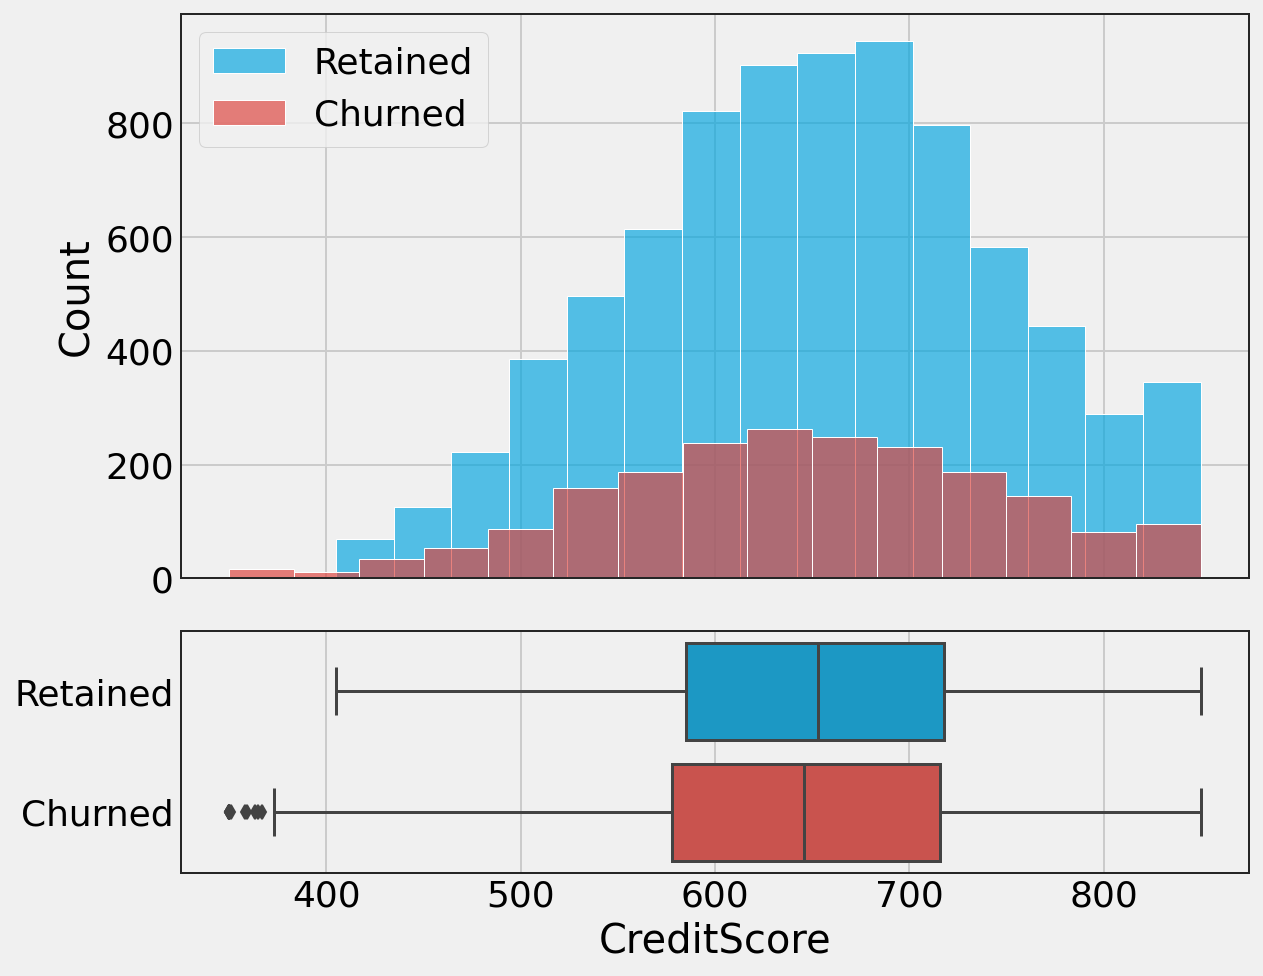

In [18]:
plot_continuous(df, 'CreditScore')

There is no significant difference between retained and churned customers regarding their credit scores.

<br>

### Balance

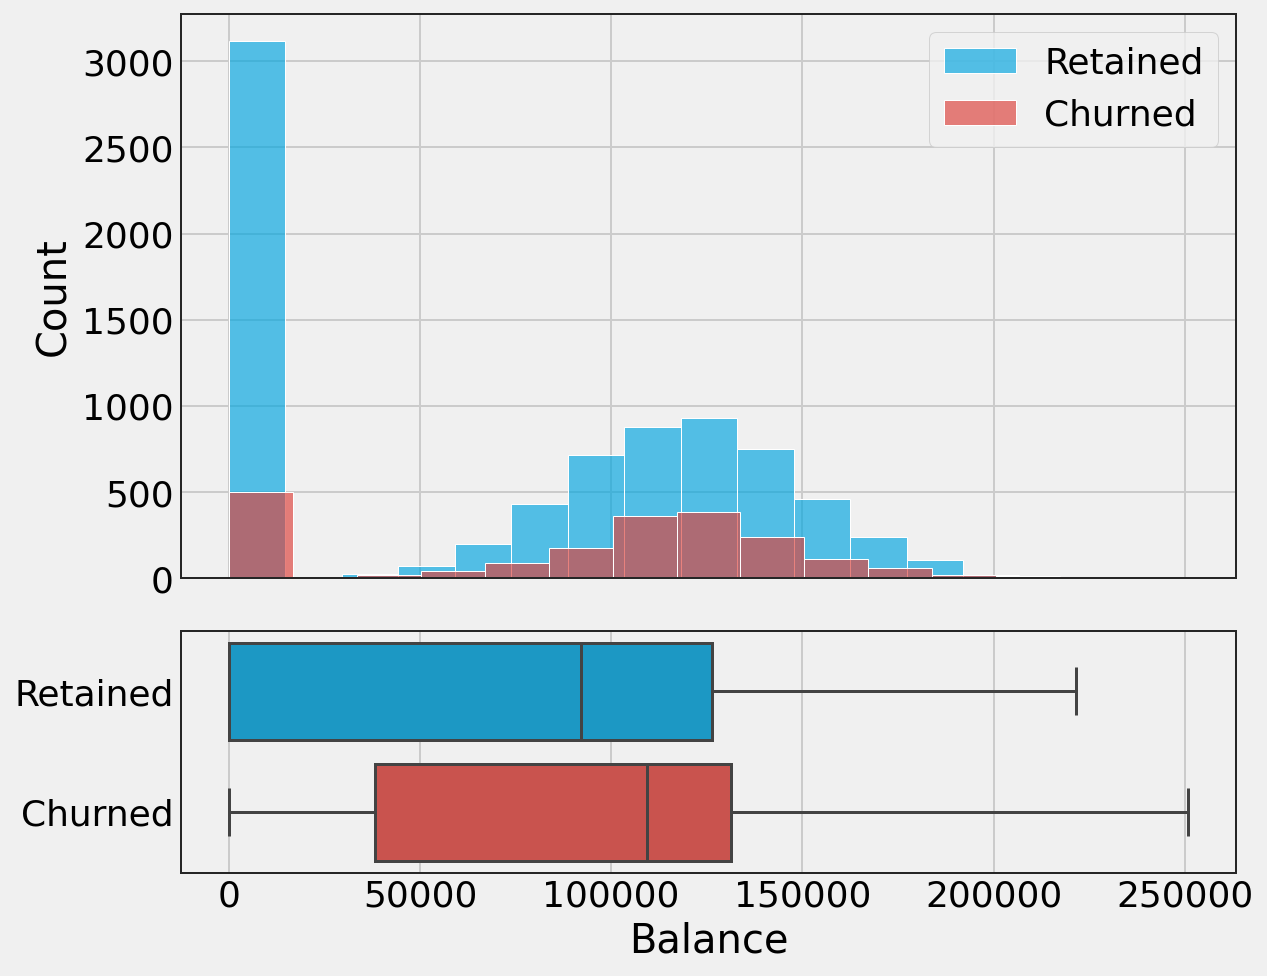

In [19]:
plot_continuous(df, 'Balance')

Again, the two distributions are pretty similar. There is a significant percentage of non-churned customers with a low account balance.

<br>

### Estimated Salary

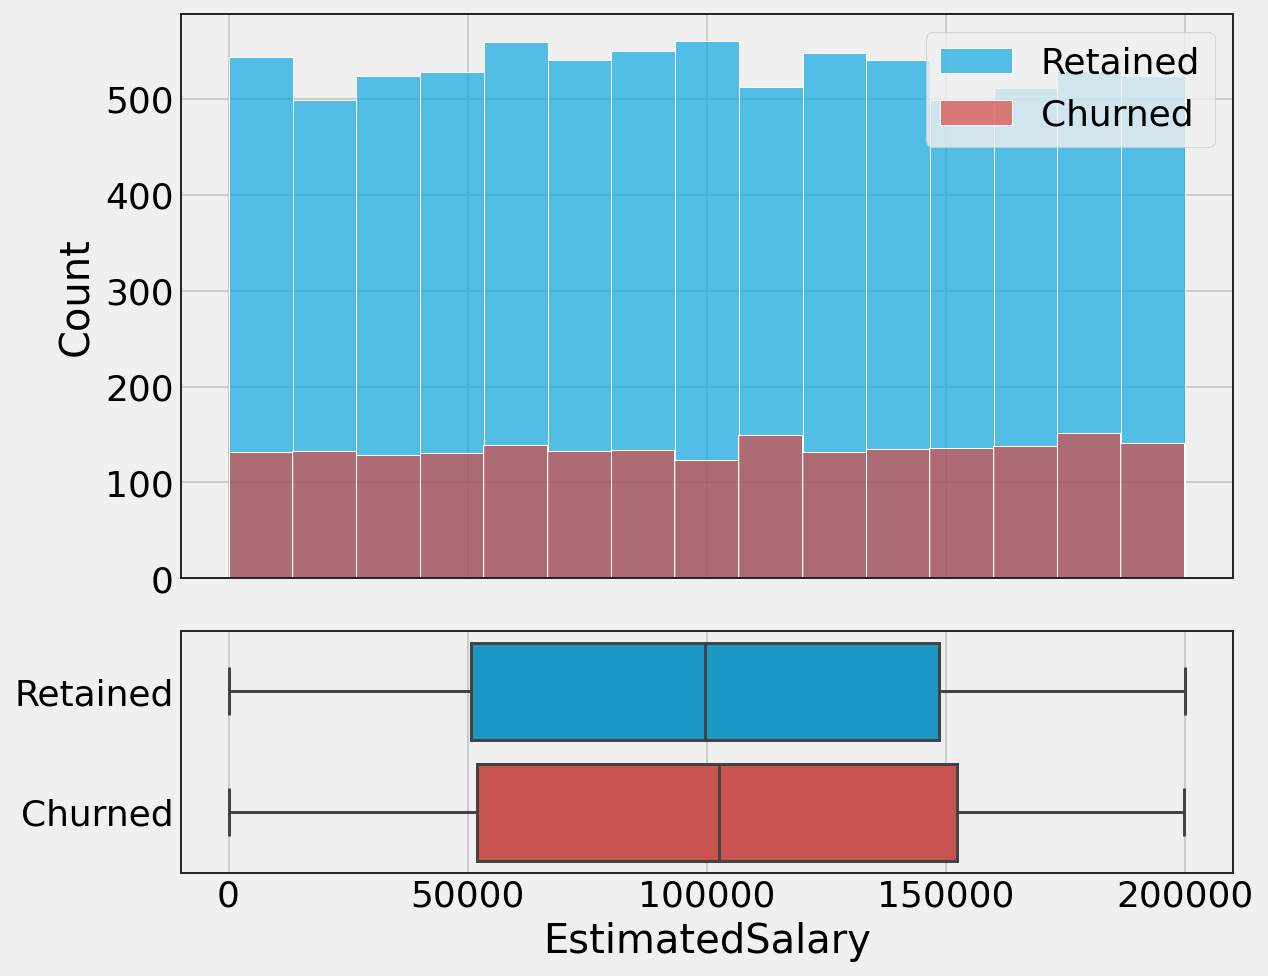

In [20]:
plot_continuous(df, 'EstimatedSalary')

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

Both churned and retained customers display a similar uniform distribution in their salaries. Consequently, we can conclude that salary does not have a significant effect on the likelihood to churn.

<br>

## Categorical Variables

Let's plot a seaborn.countplot for each categorical feature:

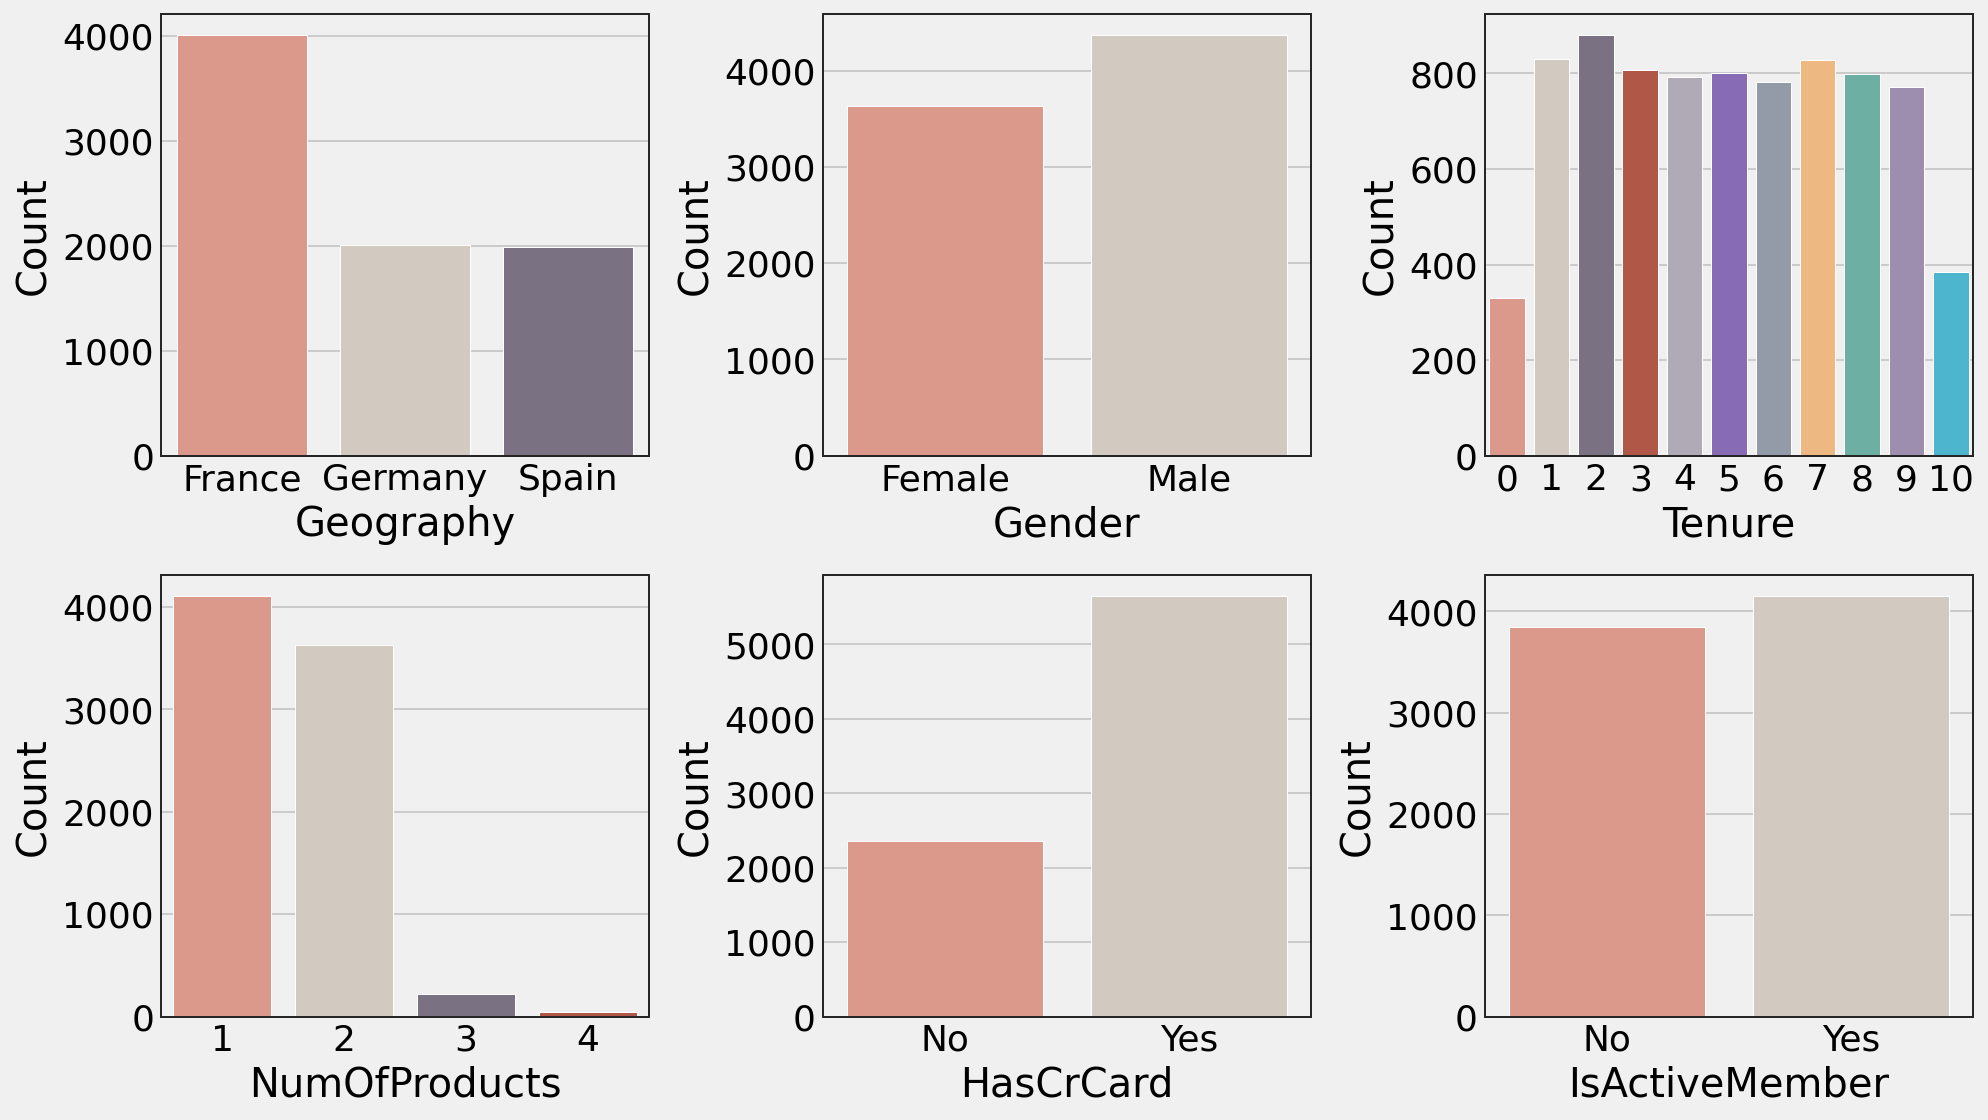

In [21]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(14, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column,
                  data=train_df,
                  edgecolor=edgecolor,
                  palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

Important points:

- The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
- There are more male customers than females,
- Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
- Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
- A significant majority of customers has a credit card, and
- Almost 50% of customers are not active.

Again, we will look at these features in greater detail.

<br>

### Geography

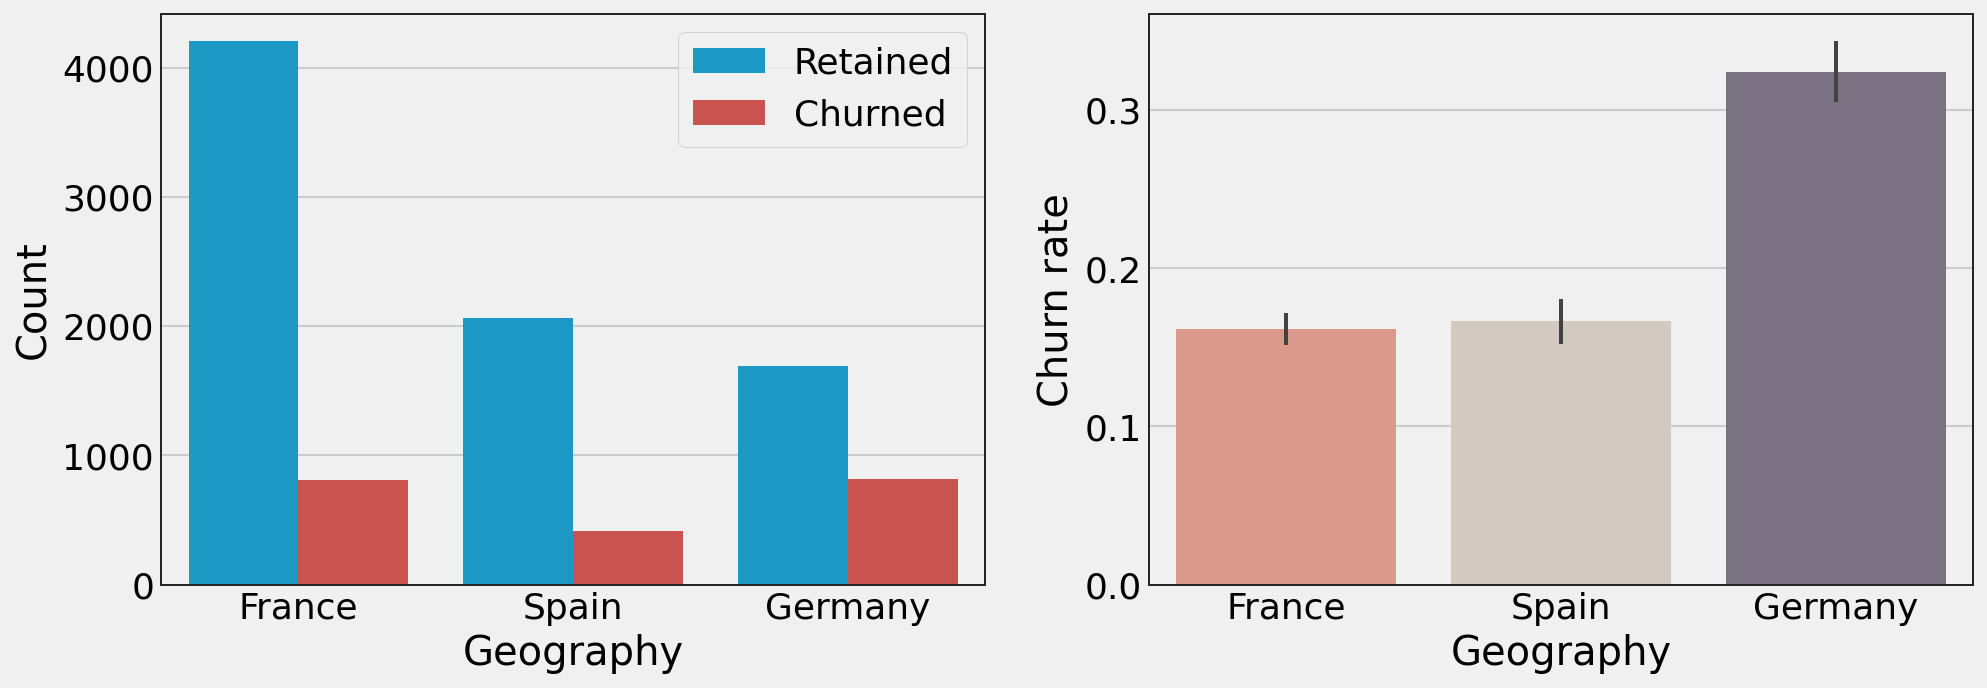

In [22]:
plot_categorical(df, 'Geography')

Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding, such as higher competition or different preferences for German customers.

<br>

### Gender

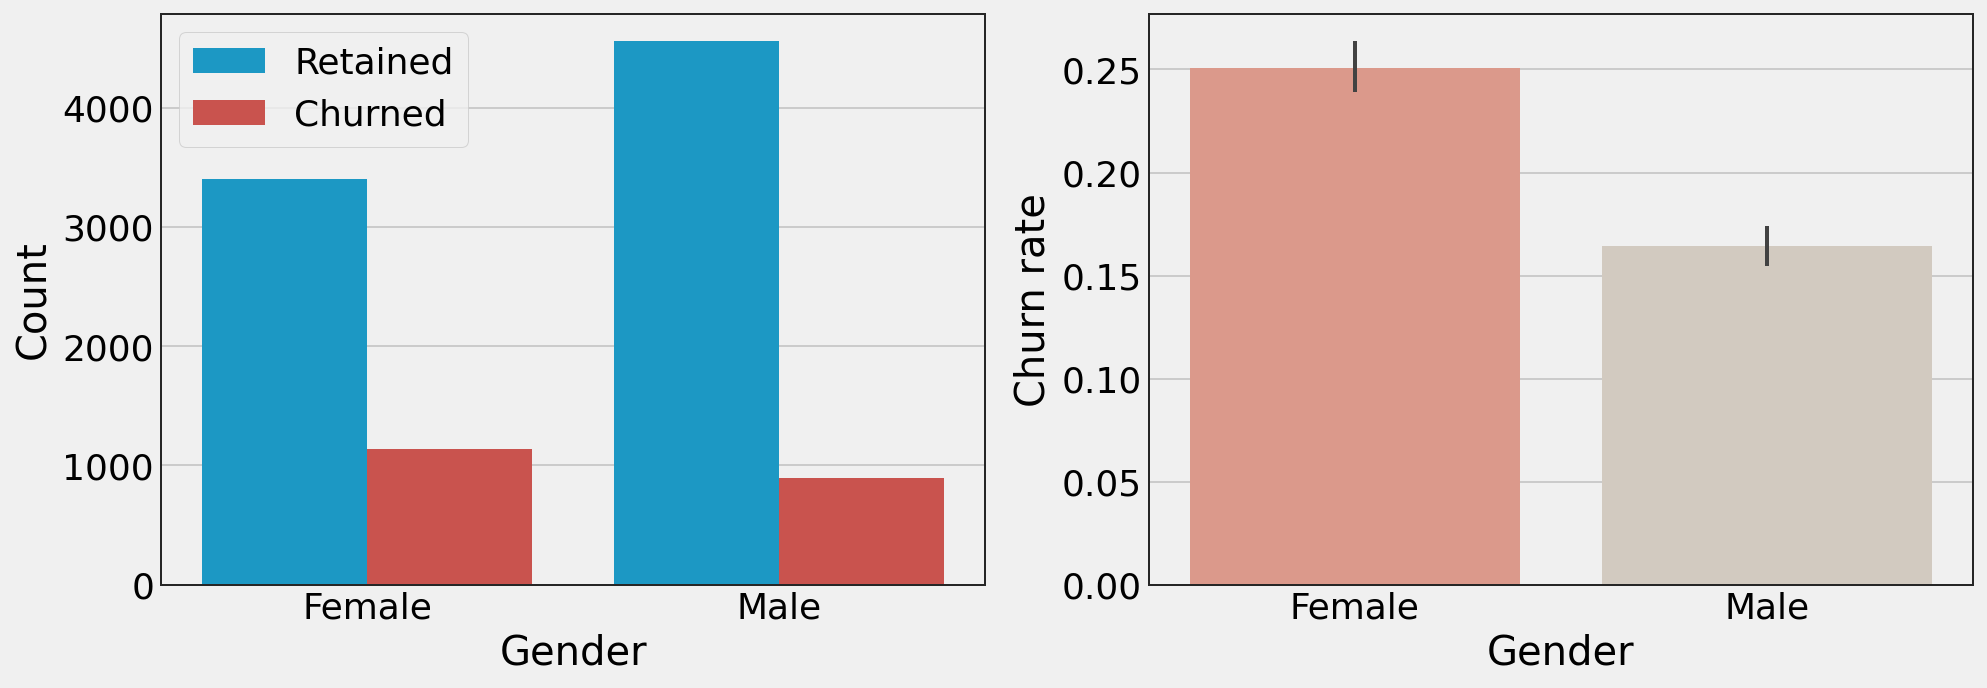

In [23]:
plot_categorical(df, 'Gender')

Female customers are more likely to churn.

<br>

### Tenure

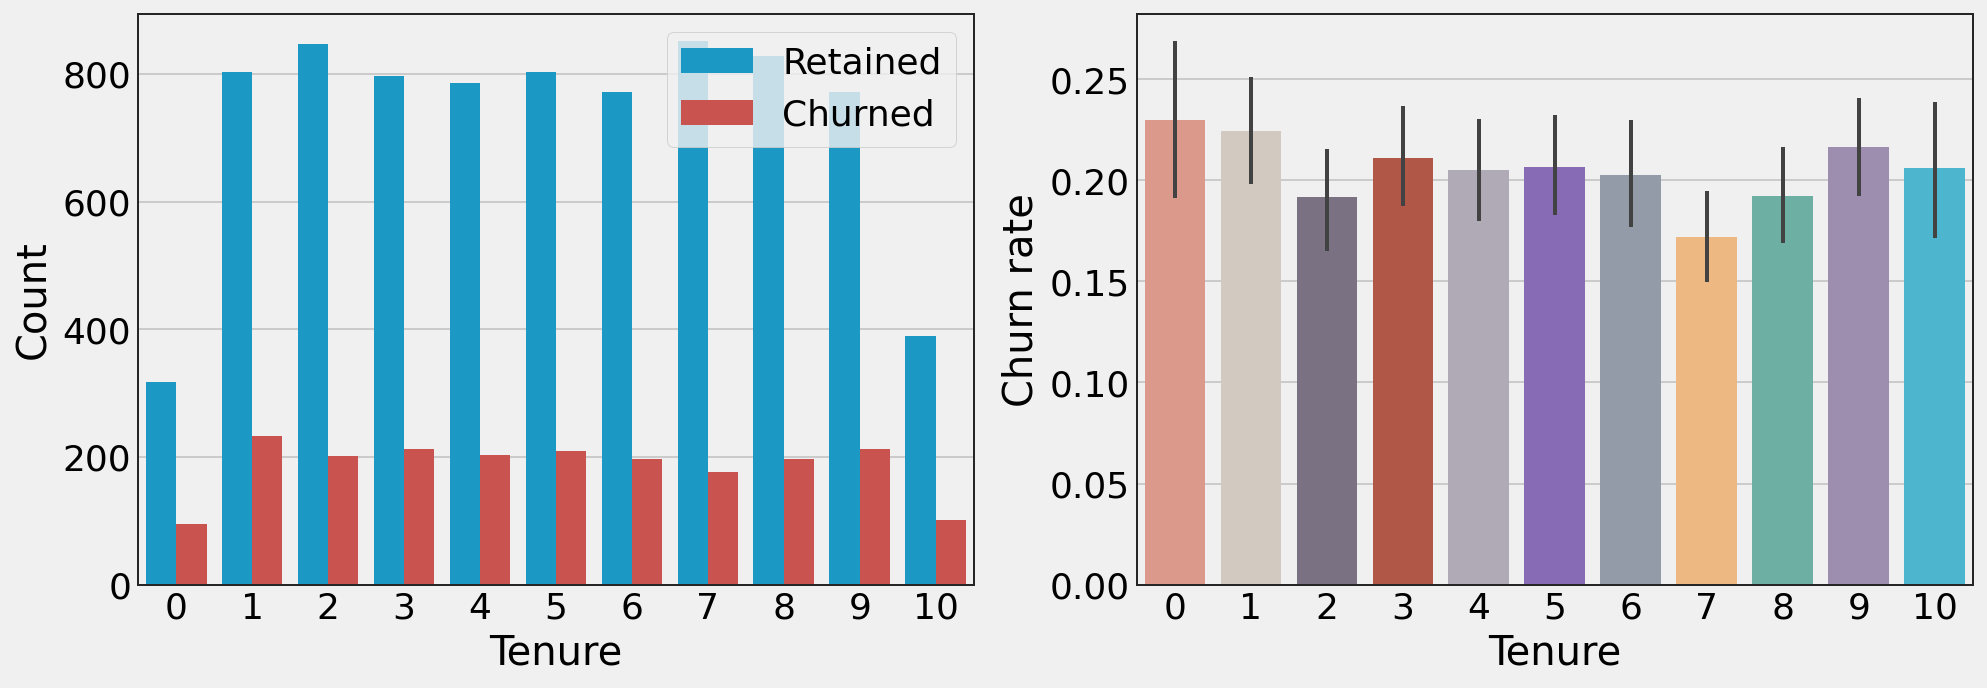

In [24]:
plot_categorical(df, 'Tenure')

The number of years (tenure) does not affect the churn rate.

<br>

### Number of Products

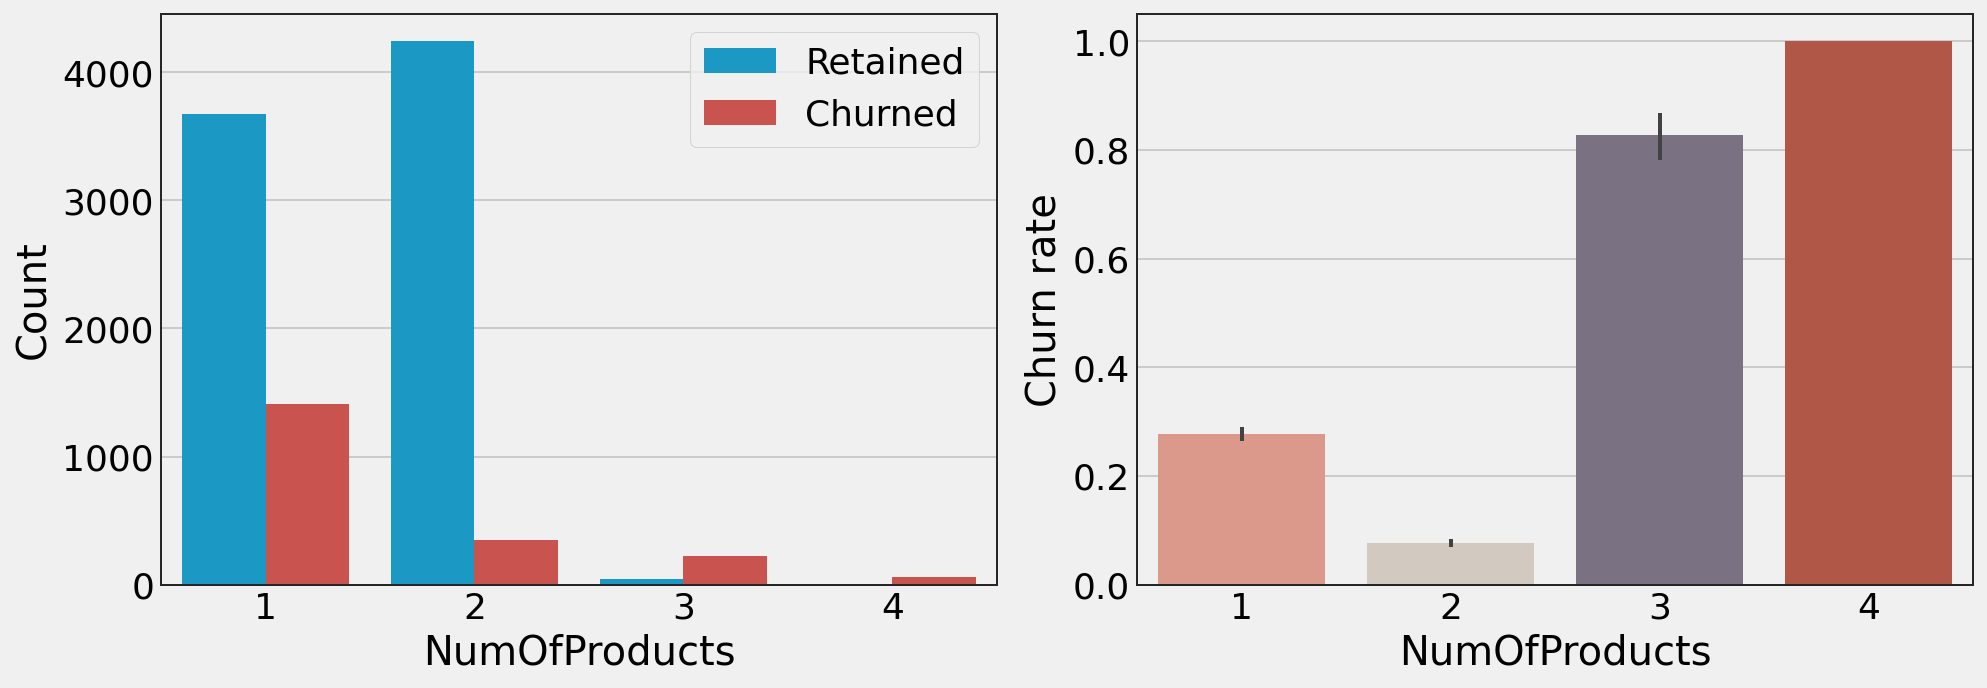

In [25]:
plot_categorical(df, 'NumOfProducts')

Interestingly, having three or four products can significantly increase the likelihood of churn. I am not sure how to interpret this result. It could potentially mean that the bank cannot properly support customers with more products, thus increasing customer dissatisfaction.

<br>

### Card Holders

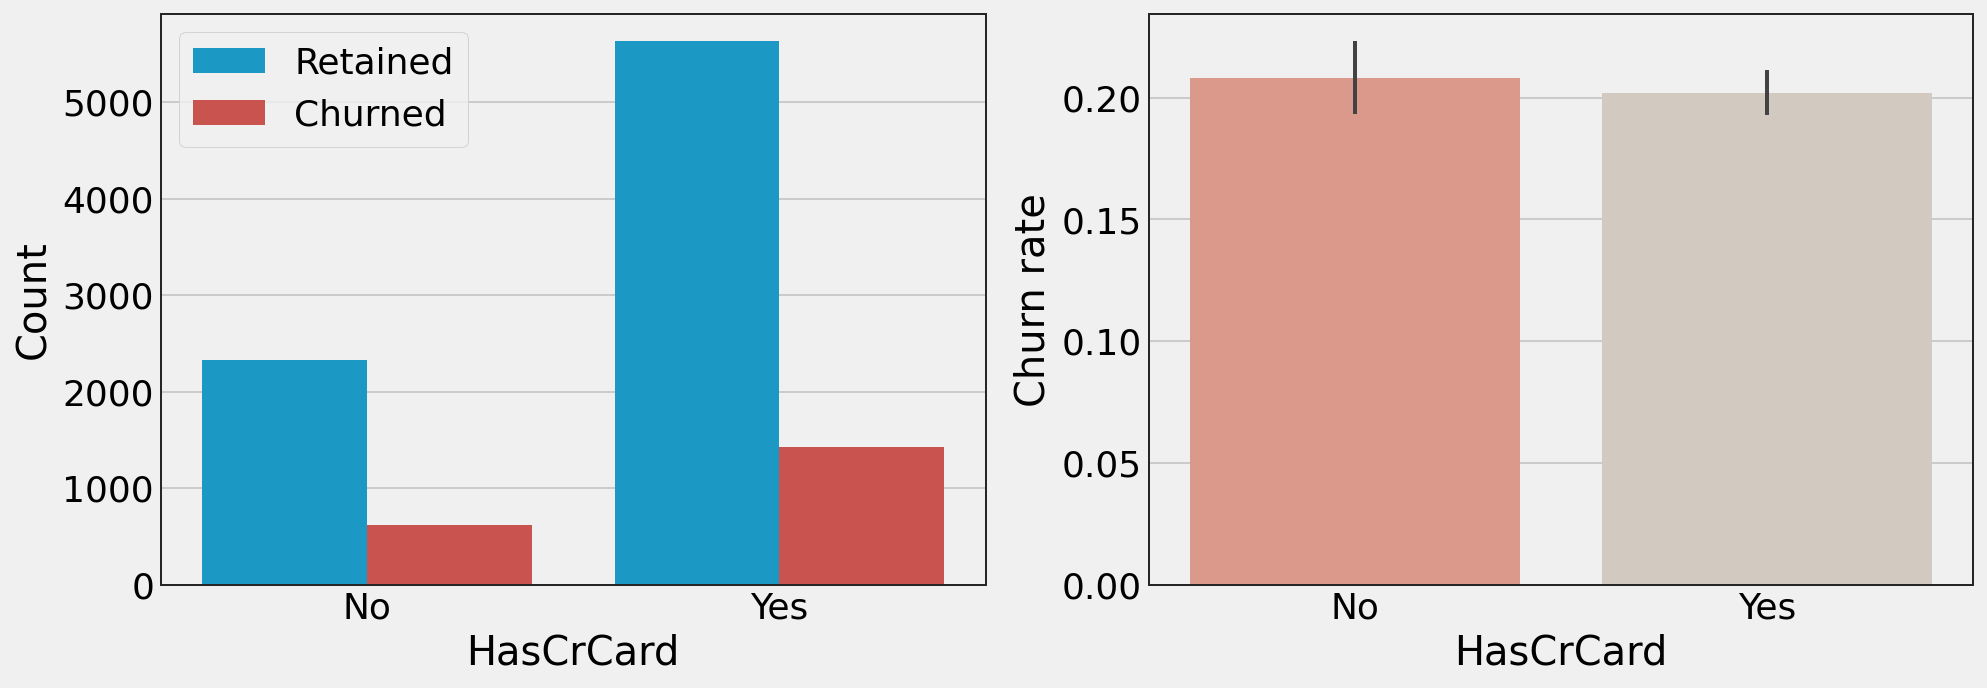

In [26]:
plot_categorical(df, 'HasCrCard')

Having a credit card does not seem to affect the churn rate.

<br>

### Active Members

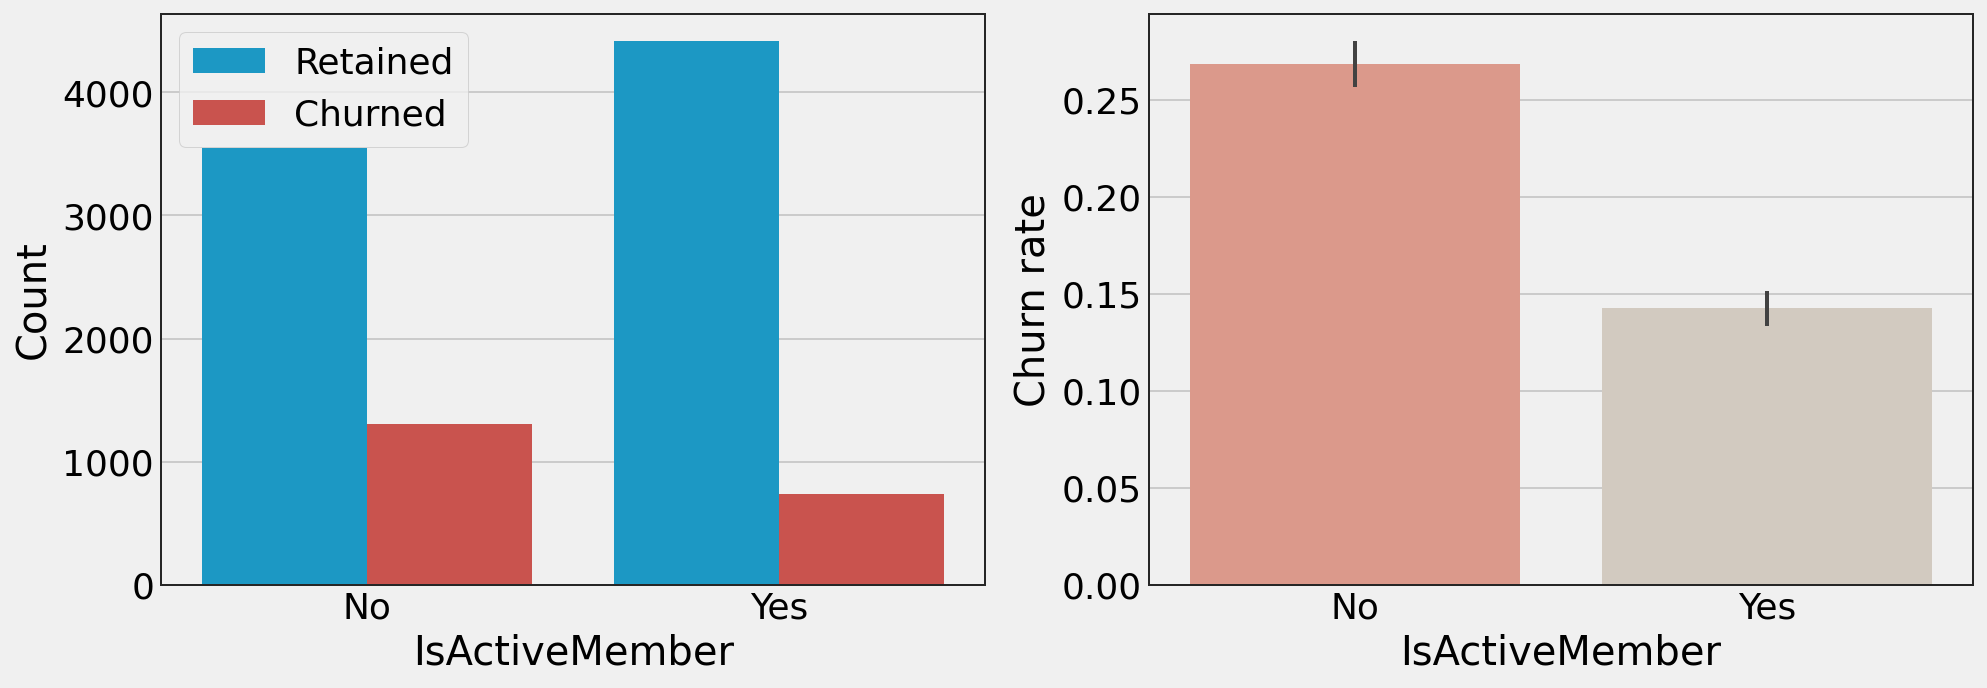

In [27]:
plot_categorical(df, 'IsActiveMember')

It is not a surprise that inactive customers are more likely to churn. A significant portion of the clientele is inactive; therefore, the bank will benefit from changing its policy so that more customers become active.

<br>

---

# Data Pre-processing

Data pre-processing is the process of converting raw data into a well-readable format that is suitable for building and training ML models.

Let's complete this process step-by-step.

<br>

## Feature Selection

We have already performed feature selection by dropping columns 'RowNumber', 'CustomerId', and 'Surname' at the beginning of our notebook. EDA revealed several more features that can be dropped as they do not provide any value in predicting our target variable:

- 'EstimatedSalary' displays a uniform distribution for both types of customers and can be dropped.
- The categories in 'Tenure' and 'HasCrCard' have a similar churn rate and are deemed redundant. This observation can be confirmed from a chi-square test (Ref. [[2](#References)]):

In [28]:
chi2_array, p_array = [], []
for column in categorical:

    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

,Variable,Chi-square,p-value
3,NumOfProducts,1215.109,3.865e-263
0,Geography,237.940,2.148e-52
5,IsActiveMember,182.644,1.283e-41
1,Gender,95.713,1.328e-22
2,Tenure,19.438,3.504e-02
4,HasCrCard,0.560,4.544e-01


'Tenure' and 'HasCrCard' have a small chi-square and a p-value greater than 0.05 (the standard cut-off value), confirming our initial hypothesis that these two features do not convey any useful information.

We can use the `drop()` method to remove these three features from the train set:

In [29]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

<br>

## Encoding Categorical Features

ML algorithms usually require all input (and output) features to be numeric. Consequently, categorical features must be converted (encoded) to numbers before building models.

Our dataset contains two features that require encoding.

- For 'Gender', we will use scikit-learn's `LabelEncoder()` which maps each unique label to an integer (Male --> 1 and Female --> 0).
- For 'Geography', we will manually map values so that customers in Germany have the value of one (1) and all other customers (France and Spain) have zero (0). We chose this method since the churn rate for customers in the other two countries is almost equal and considerably lower than in Germany. Therefore, it makes sense to encode this feature to differentiate between German and non-German customers. Additionally, I tried one-hot encoding (`get_dummies()`) this feature, and the two new features for France and Spain had small feature importance.


In [30]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

<br>

## Scaling

Feature scaling is a technique used to normalise the range of features. Some algorithms are sensitive to feature scaling (e.g. SVMs), while others are invariant (e.g. Random Forests).

I decided to use scikit-learn's `StandardScaler()`, which standardises features by subtracting the mean and dividing by the standard deviation. This transformation results in features with zero mean and unit variance.

In [31]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

Finally, we will split the train set into 'X_train' and 'y_train' sets:

In [32]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

<br>

## Addressing Class Imbalance

As we have seen previously, there is an imbalance in the classes to be predicted, with one class (0 – retained) much more prevalent than the other (1 - churned):

In [33]:
y_train.value_counts()

0    6370
1    1630
Name: Exited, dtype: int64

Class imbalance is usually a problem and occurs in many real-world tasks. Classification using imbalanced data favours 
the majority class, meaning that ML algorithms will likely result in models that do little more than predict the most common class. Also, common metrics can be misleading when handling class-imbalanced data (e.g. if a dataset contains 99.9% 0s and 0.1% 1s, a classifier that always predicts 0 will have 99.9% accuracy).

Thankfully, some methods can address this problem. **Resampling** is a widely adopted technique designed to alter the class distribution in the training dataset. It consists of removing instances of the majority class (**Undersampling**) and/or adding copies of instances from the minority class (**Oversampling**). Additionally, there are algorithms for generating **synthetic** instances of the minority class. For example, as we read in Ref. [[2](#References)], the **SMOTE** ('Synthetic Minority Oversampling Technique') algorithm '*finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighbouring record, where the weight is generated separately for each predictor*'.

In this project, we will leave our dataset untouched and use the same algorithms but give them a different perspective on the problem. **Penalised classification** imposes an additional cost on the model for making classification mistakes on the minority class during training. These penalties can bias the model to pay more attention to the minority class (Ref. [[9](#References)]). For most algorithms, penalised classification is implemented by including an extra hyperparameter called `class_weight` and setting it equal to `balanced`.

<br>

## Pre-processing the Test Set

We need to perform the same pre-processing steps for the test set as we did for the training set.

In [34]:
test_df = test_df.drop(features_drop, axis=1)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)

<br>

---

# Building Machine Learning Models

## Baseline Models

In this section, we will create two simple models to estimate the **baseline performance** on the training set. Specifically, we will use the Gaussian Naïve Bayes and Logistic Regression algorithms.

We will use their default parameters and evaluate their (mean) AUC score by performing **k-fold cross-validation**. The idea behind k-fold cross-validation, illustrated in [this figure](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png), is simple: it splits the (training) set into k subsets/folds, trains the models using k-1 folds, and evaluates the model on the remaining one fold. This process is repeated until every fold is tested once. We will define the number of folds as a separate variable, `cv`, equal to 5. By setting this variable as an integer, stratified sampling will be used to create the folds.

In [35]:
scoring_metric = 'roc_auc'
cv = 5  # If int, StratifiedKFold is used.

In [36]:
clf_list = [('GNB', GaussianNB()),
            (' LR', LogisticRegression(random_state=random_state,
                                       class_weight='balanced'))]

cv_base_mean, cv_base_std = [], []
for clf in clf_list:

    cv_scores = cross_val_score(estimator=clf[1],
                                X=X_train,
                                y=y_train,
                                scoring=scoring_metric,
                                cv=cv,
                                n_jobs=-1)

    cv_base_mean.append(cv_scores.mean())
    cv_base_std.append(cv_scores.std())

print('Baseline Models - CV ({}) Score:'.format(scoring_metric))
for i in range(len(clf_list)):
    print('   {}: {} ± {}'.format(clf_list[i][0],
                                  np.round(cv_base_mean[i], 3),
                                  np.round(cv_base_std[i], 3)))

Baseline Models - CV (roc_auc) Score:
   GNB: 0.797 ± 0.005
    LR: 0.771 ± 0.009


<br>

## Model Tuning

We are now ready to start building ML models. The seven classifiers we will use are:

1) [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), <br>
2) [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), <br>
3) [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), <br>
4) [Balanced Random Forest Classifier](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), <br>
5) [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), <br>
6) [Xtreme Gradient Boosting Classifier](https://xgboost.readthedocs.io/en/latest/), and <br>
7) [Light Gradient Boosting Machine](https://lightgbm.readthedocs.io/en/latest/).

We will not go into detail about how these algorithms work. More information can be found in  Ref. [[1](#References)] or the corresponding documentation.

Using default hyperparameters usually results in non-optimised models that overfit or underfit the dataset. **Hyperparameter tuning** is the process of finding the set of hyperparameter values that achieves optimal performance. For this purpose, we will first define which hyperparameters we want to experiment with and what values to try out. We will pass this information to Scikit-Learn’s `GridSearchCV`, which evaluates all the possible combinations of hyperparameter values. As mentioned earlier, **roc_auc** will be the scoring metric for optimising the models. Note that `GridSearchCV` evaluates the performance by performing k-fold cross-validation; therefore, the number of folds must be provided. We will set this parameter equal to 5, as we did earlier for the baseline performance.

<br>

### Logistic Regression


 Logistic Regression
-------------------------------
   Best Score (roc_auc): 0.772
   Best Parameters: 
      C: 0.01
      max_iter: 50
      penalty: l2
      solver: lbfgs


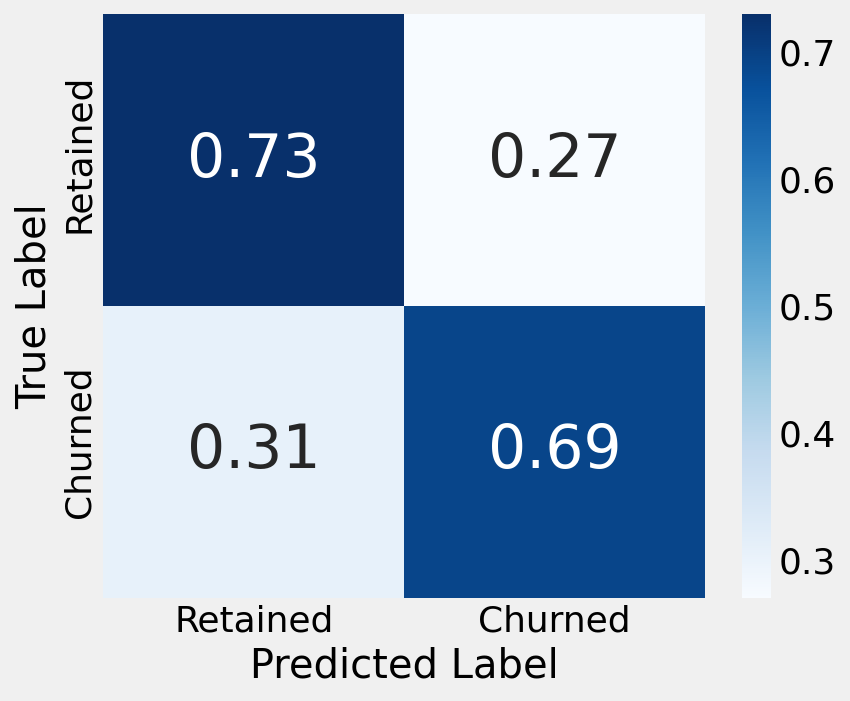

In [37]:
lr = LogisticRegression(random_state=random_state, class_weight='balanced')

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'max_iter': [50, 100, 500]
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=cv,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR', cv)

<br>

### Support Vector Classifier


 Support Vector Classifier
-------------------------------
   Best Score (roc_auc): 0.861
   Best Parameters: 
      C: 1
      gamma: auto
      kernel: rbf


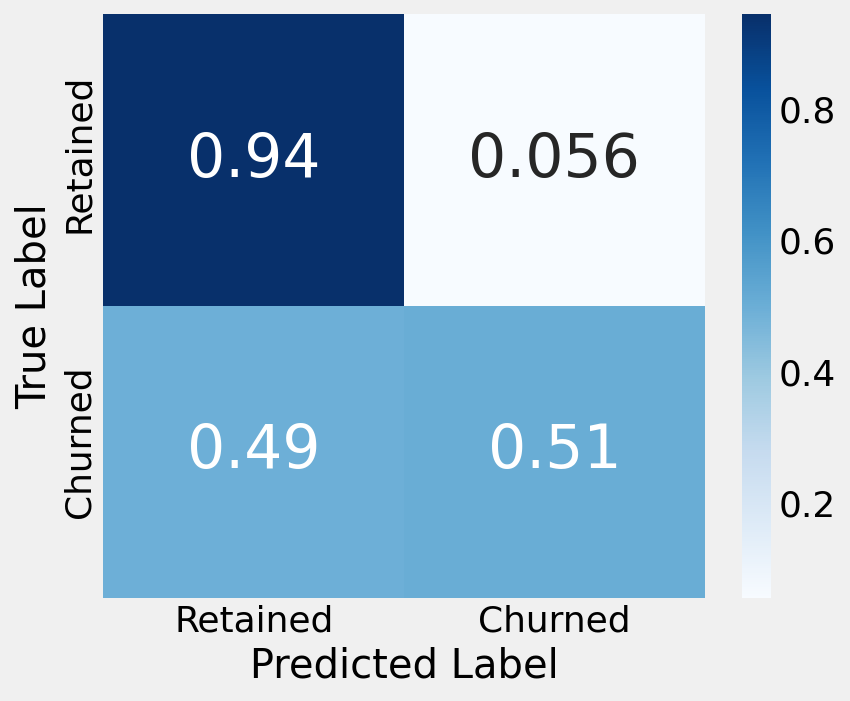

In [38]:
svc = SVC(probability=True, random_state=random_state, class_weight='balanced')

param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=cv,
                       verbose=False,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC', cv)

<br>

### Random Forest

There are two variations of the standard Random Forest classifier that are suited for imbalanced classification (Ref. [[8](#References)]):

1) **Random Forest With Class Weighting**: This variation is implemented by setting the `class_weight` parameter to `balanced`, which changes each class's weight when calculating the impurity score of a chosen split point.

2) **Random Forest With Bootstrap Class Weighting**: This variation is implemented by setting the `class_weight` parameter to `balanced_subsample`. This variation is different from the first, as it changes the class weighting based on the class distribution in each bootstrap sample instead of the entire training dataset.


 Random Forest
-------------------------------
   Best Score (roc_auc): 0.853
   Best Parameters: 
      bootstrap: True
      class_weight: balanced
      criterion: gini
      max_depth: 5
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 5
      n_estimators: 100


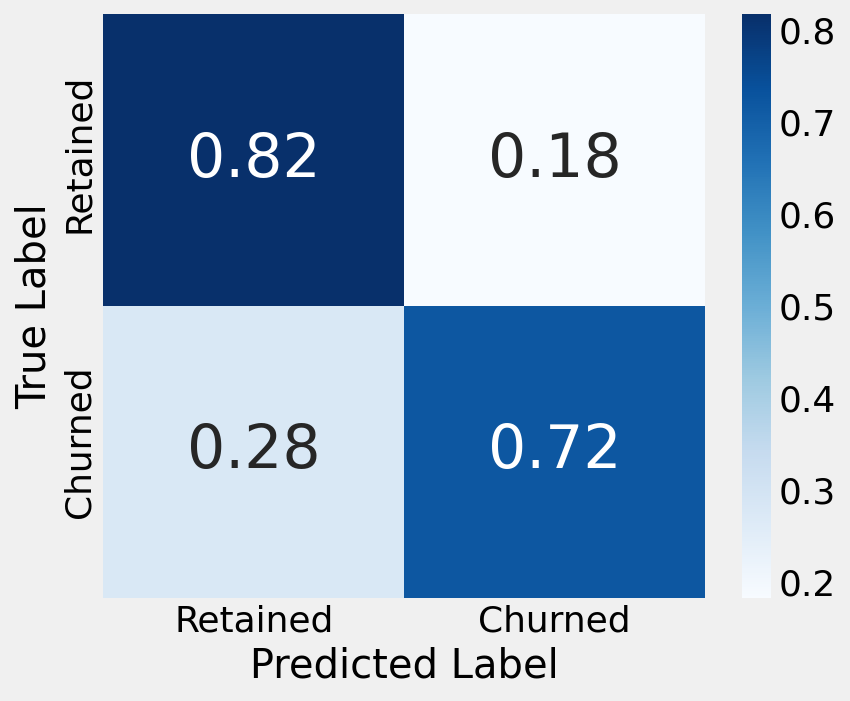

In [39]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],  # default=100
    'criterion': ['entropy', 'gini'],
    'max_depth': [5],  # default=None
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=cv,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF', cv)

<br>

### Random Forest With Random Undersampling

A third variation of the Random Forest classifier performs data resampling on the bootstrap sample to explicitly change the class distribution. The `BalancedRandomForestClassifier` algorithm is provided by the `imbalanced-learn` package.


 Balanced Random Forest
-------------------------------
   Best Score (roc_auc): 0.853
   Best Parameters: 
      bootstrap: True
      class_weight: balanced_subsample
      criterion: gini
      max_depth: 5
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 5
      n_estimators: 100
      sampling_strategy: auto


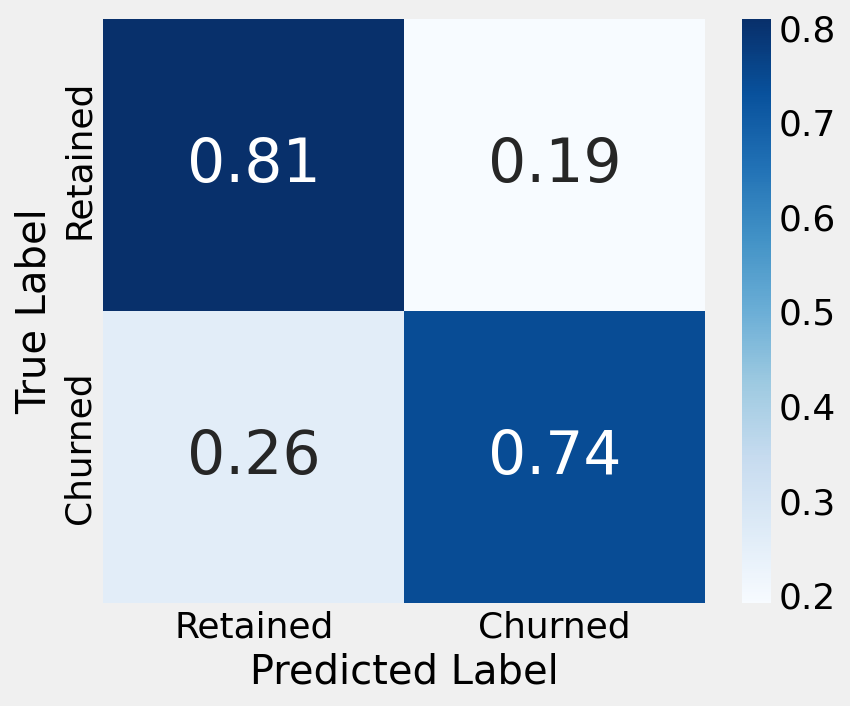

In [40]:
brf = BalancedRandomForestClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'max_depth': [5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'sampling_strategy': ['auto'],
    'class_weight': ['balanced', 'balanced_subsample']
}

brf_clf = GridSearchCV(estimator=brf,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=cv,
                       verbose=False,
                       n_jobs=-1)

best_brf_clf = brf_clf.fit(X_train, y_train)
clf_performance(best_brf_clf, 'Balanced Random Forest', 'BRF', cv)

<br>

### Gradient Boosting Classifier


 Gradient Boosting Classifier
-------------------------------
   Best Score (roc_auc): 0.859
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 4
      max_features: log2
      min_samples_leaf: 7
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


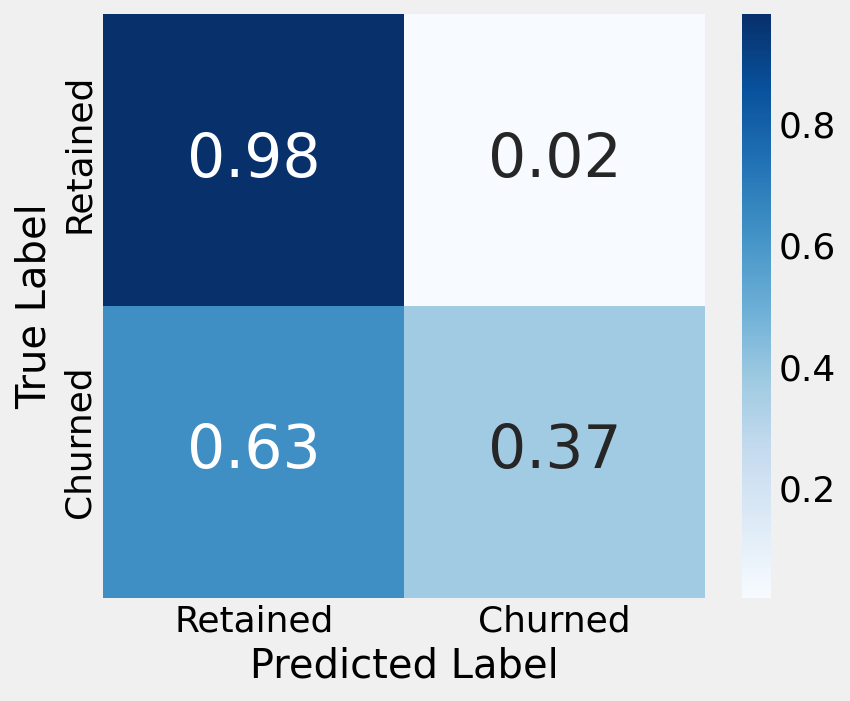

In [41]:
gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'learning_rate': [0.001, 0.01],
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [5, 7],
    'max_depth': [4],  # default=3
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=cv,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC', cv)

The number of estimators after early stopping is:


In [42]:
best_gbc_clf.best_estimator_.n_estimators_

186

<br>

### XGBoost Classifier


 XGBoost Classifier
-------------------------------
   Best Score (roc_auc): 0.857
   Best Parameters: 
      colsample_bytree: 0.75
      gamma: 0.1
      learning_rate: 0.01
      max_depth: 6
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 10
      reg_lambda: 10
      scale_pos_weight: 5
      subsample: 0.75


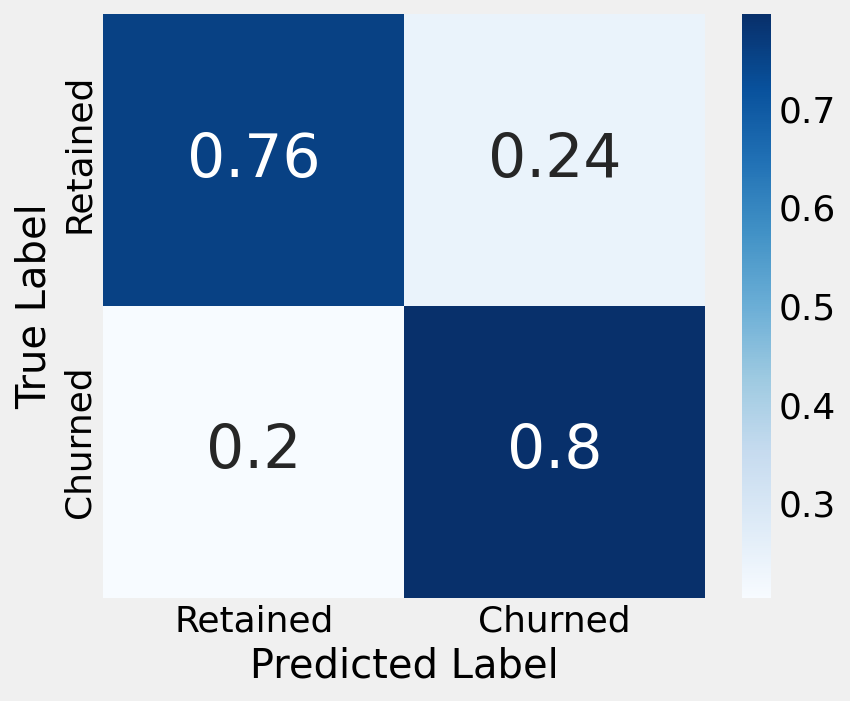

In [43]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]  # Ratio of number of negative class to the positive class - Needed for XGB classifier
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [6],  # default=6
    'reg_alpha': [10],
    'reg_lambda': [10],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 1, 10],
    'min_child_weight': [1, 2],
    'scale_pos_weight': [ratio, 5]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=cv,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB', cv)

<br>

### LGBMClassifier

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75

 LGBMClassifier
-------------------------------
   Best Score (roc_auc): 0.866
   Best Parameters: 
      class_weight: {0: 0.35, 1: 0.65}
      feature_fraction: 0.75
      is_unbalance: True
      learning_rate: 0.01
      max_depth: 10
      min_child_samples: 5
      n_estimators: 100
      num_leaves: 20
      reg_alpha: 0.1
      reg_lambda: 0.1
      subsample: 0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

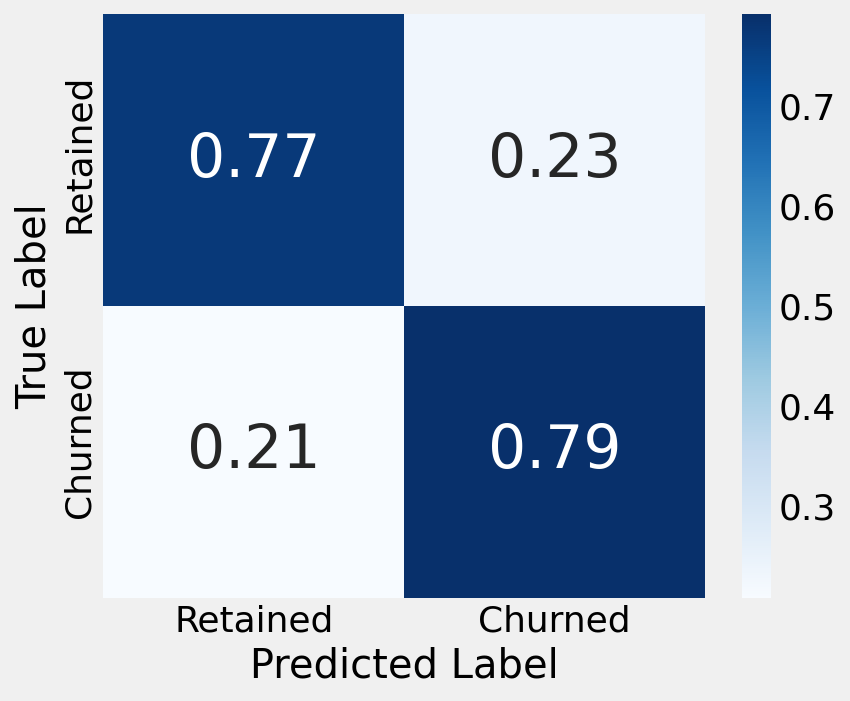

In [44]:
lgbm = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [10],
    'num_leaves': [20],
    'learning_rate': [0.01],
    'n_estimators': [100],
    'feature_fraction': [0.75],
    'subsample': [0.75],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5],
    'is_unbalance': [True],
    'class_weight': ['balanced', {0: 0.35, 1: 0.65}]
}

lgbm_clf = GridSearchCV(estimator=lgbm,
                        param_grid=param_grid,
                        scoring=scoring_metric,
                        cv=cv,
                        verbose=False,
                        n_jobs=-1)

best_lgbm_clf = lgbm_clf.fit(X_train, y_train)
clf_performance(best_lgbm_clf, 'LGBMClassifier', 'LGBM', cv)

<br> 

### Ensemble Learning

We can combine the predictions of all these classifiers to determine if we get better predictive performance compared to each individual constituent classifier. This practice is the main motivation behind Ensemble Learning.

Specifically, we will use **Soft Voting**. In this case, every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.

Soft Voting
-------------------------------
   Best Score (roc_auc):  0.859


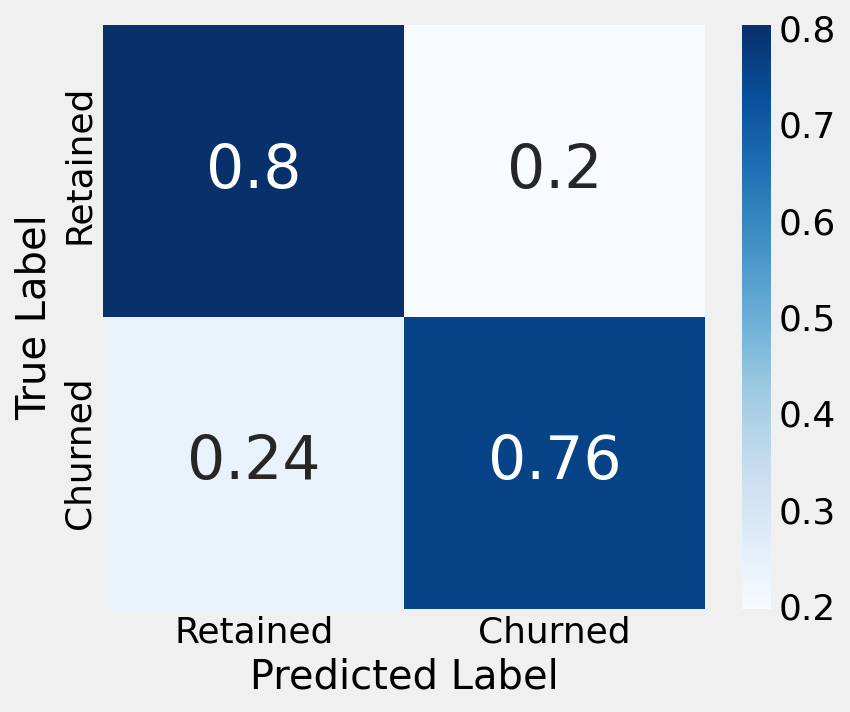

In [45]:
estimators = [('LR', best_lr_clf.best_estimator_),
#               ('SVC', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('BRF', best_brf_clf.best_estimator_),
#               ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('LGBM', best_lgbm_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=cv,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-------------------------------')
print('   Best Score ({}): '.format(scoring_metric),np.round(roc_auc_score(y_train, y_pred_pp), 3))

fig, ax = plt.subplots(figsize=(6, 5))

plot_conf_mx(cm, ax)

<br>

# Results

## Feature Importance

Some classifiers allow us to visualise feature importance, i.e. how useful a feature is in predicting the target variable. 

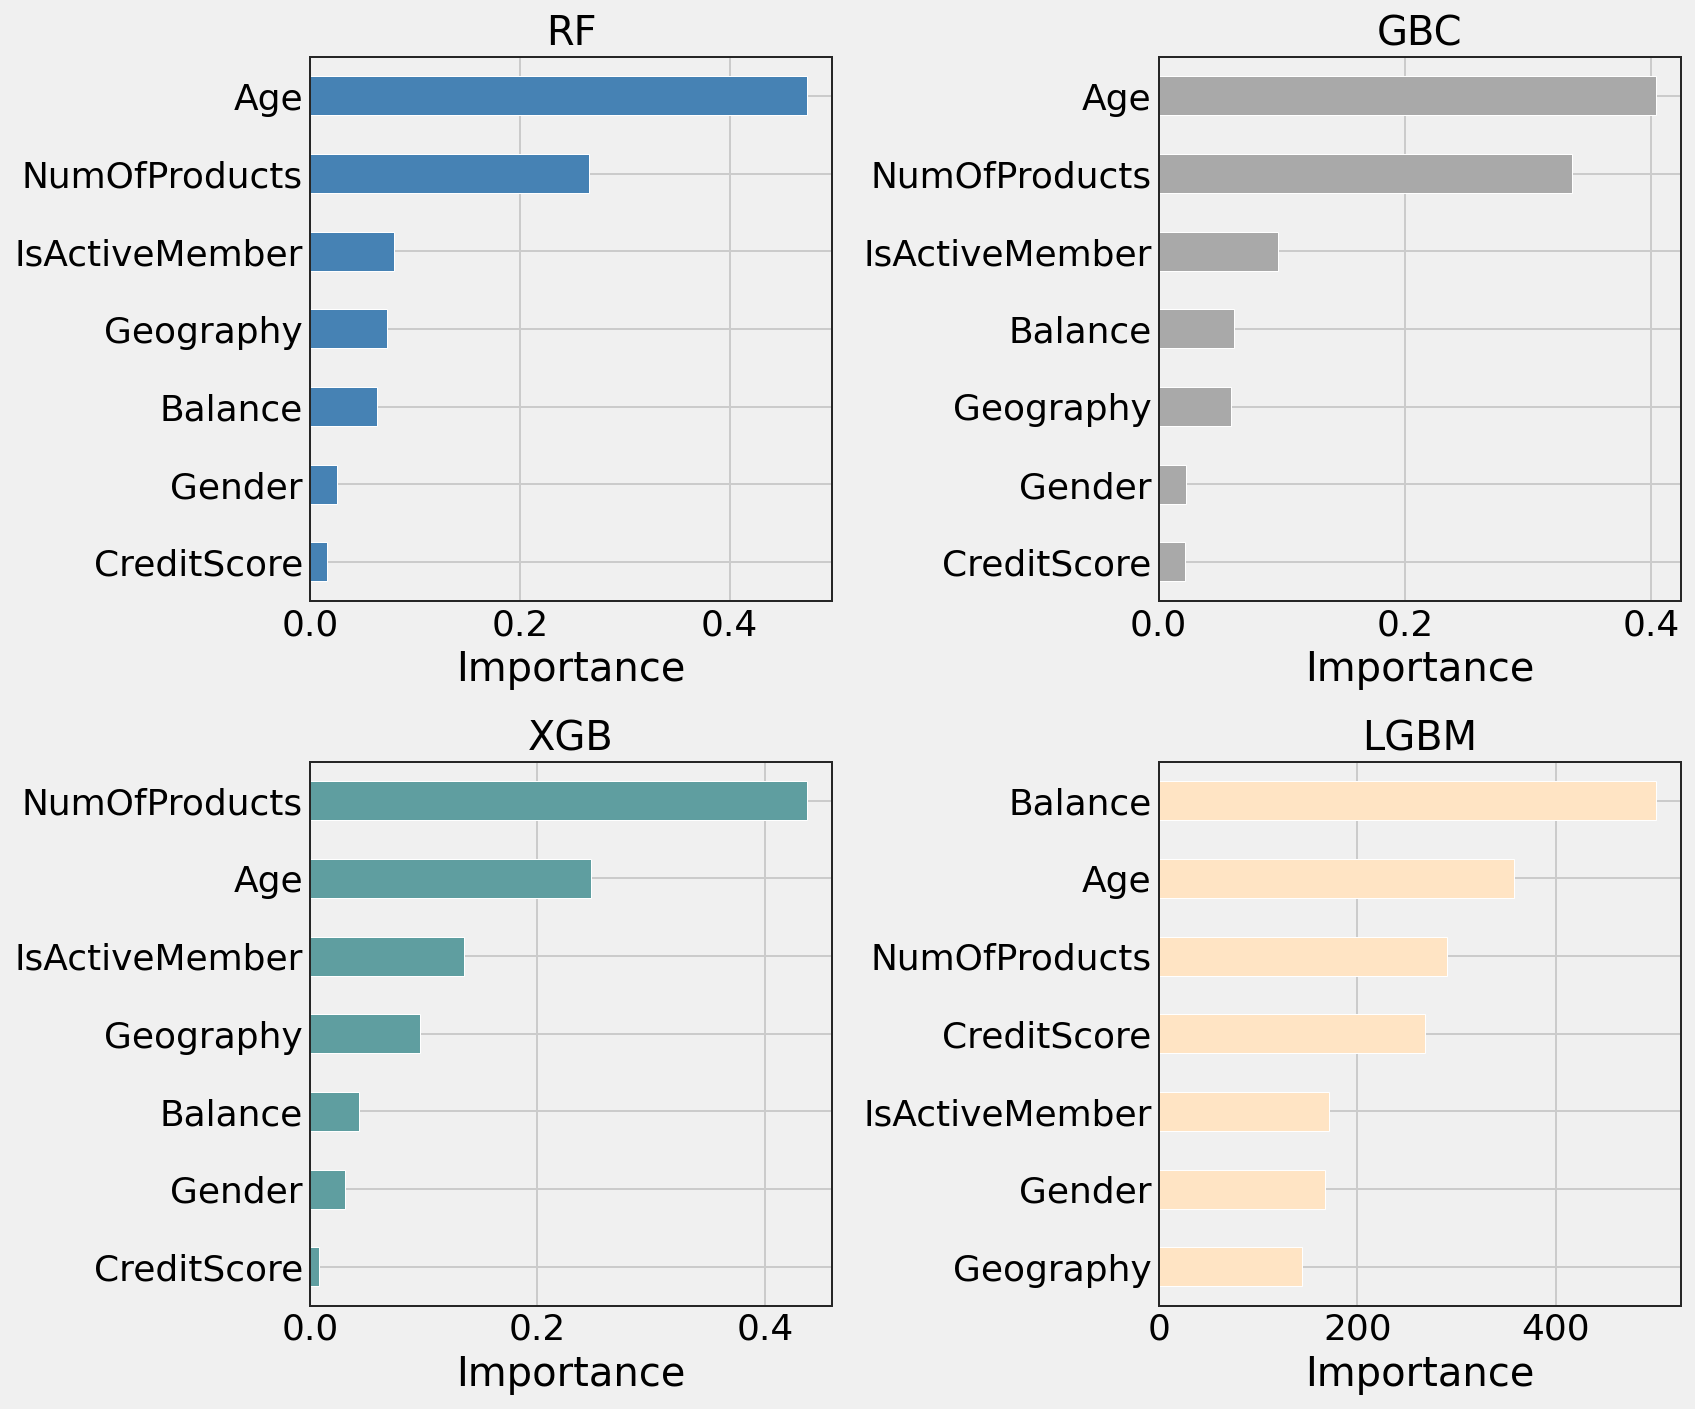

In [46]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(2, 2, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'GBC', 'XGB', 'LGBM'],
                                    [best_rf_clf, best_gbc_clf, best_xgb_clf, best_lgbm_clf])):

    fi = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': clf.best_estimator_.feature_importances_
    }).sort_values('Importance', ascending=True).set_index('Feature')

    ax = plt.subplot(2, 2, i + 1)

    fi.plot.barh(color=colors_fi[i],
                 edgecolor=edgecolor,
                 legend=False,
                 ax=ax)

    ax.set_title(name)
    ax.set(xlabel='Importance', ylabel='')

plt.tight_layout();

The first three classifiers ('RF', 'GBC', and 'XGB') display similar behaviour: 'Age' and 'NumOfProducts' seem like the most useful features, followed by 'IsActiveMember'. On the other hand, 'CreditScore' is the least important feature with a small value close to zero.

In contrast, 'Balance' is the most important feature for the LGBM model, followed by 'Age'. For the same classifier, 'CreditScore' is placed in the middle of the leaderboard.

<br>

## Performance Comparison

Initially, we can compare the performance of our classifiers in terms of three individual metrics (Precision, recall, and area under the ROC curve):

In [47]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:3]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

,Precision,Recall,AUC
LR,0.397,0.694,0.772
SVC,0.698,0.506,0.860
RF,0.503,0.723,0.853
BRF,0.498,0.743,0.852
GBC,0.829,0.372,0.859
XGB,0.457,0.796,0.856
LGBM,0.468,0.792,0.865
SVot,0.495,0.758,0.859


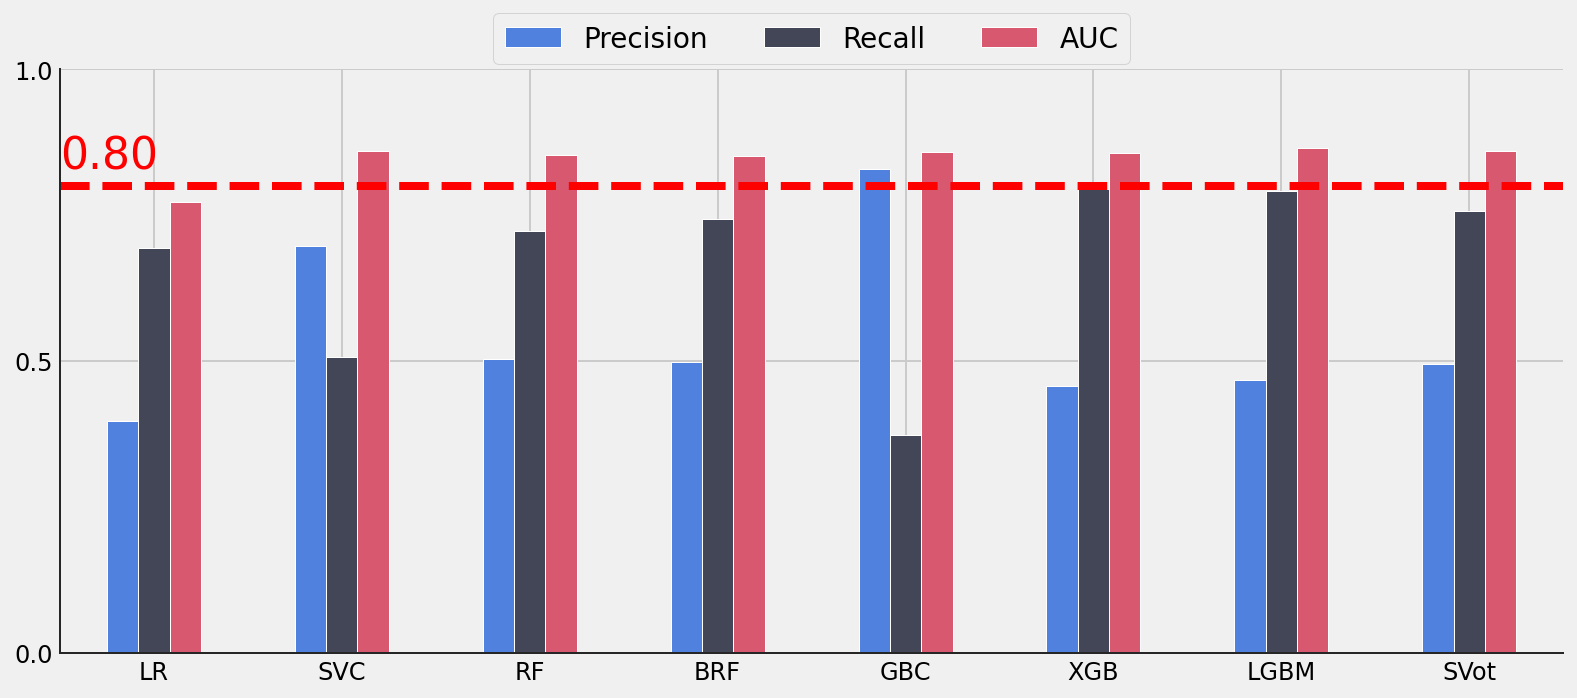

In [48]:
fig, ax = plt.subplots(figsize=(12, 5))

comparison_df.plot(kind='bar',
                   fontsize=12,
                   color=['#5081DE', '#424656', '#D85870'],
                   edgecolor=edgecolor,
                   ax=ax)

ax.legend(loc='upper center',
          fontsize=font_size - 6,
          ncol=len(comparison_df.columns),
          bbox_to_anchor=(0.5, 1.12))

ax.set_ylim([0, 1])

ax.xaxis.set_tick_params(which='major', rotation=0)
ax.set_yticks([0, 0.5, 1])

ax.axhline(y=0.80, color='red', linestyle='--')
ax.text(x=-0.5, y=0.83, s='0.80', size=font_size + 2, color='red')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

<br>

Apart from Logistic Regression, all other classifiers have an AUC score higher than 0.80 (baseline performance). The **LGBM model** has the **highest AUC score** (**0.865**). However, apart from the GBC model, almost all classifiers display a **similar performance** with an AUC score around 0.860 (and similar scores for the other three metrics).

Using single metrics is not the only way of comparing the predictive performance of classification models. The ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classifier at different classification thresholds. It plots the true positive rate (another name for recall) against the false positive rate.

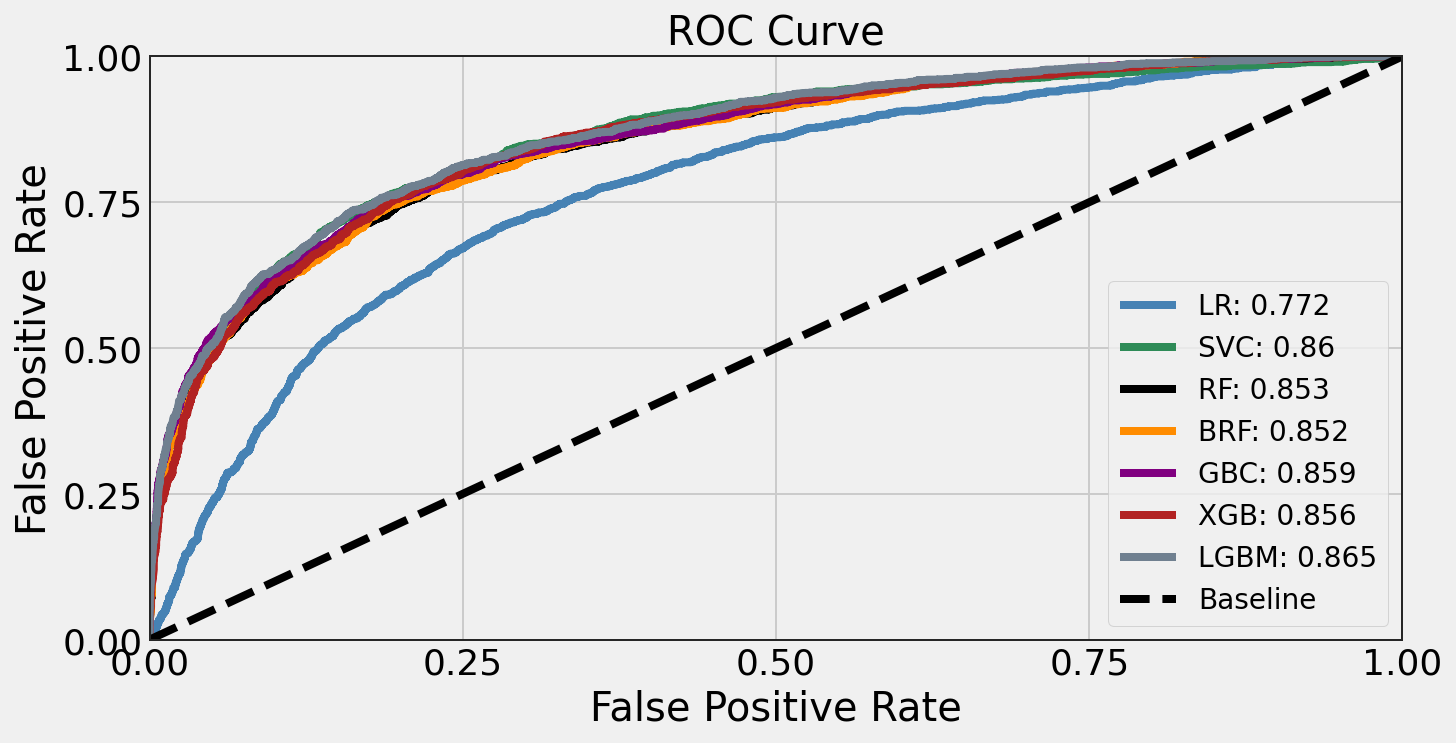

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    if key == 'SVot': continue

    auc = comparison_dict[key][2]
    fpr, tpr = comparison_dict[key][3], comparison_dict[key][4]
    
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set(title='ROC Curve',
       xlabel='False Positive Rate',
       ylabel='False Positive Rate')

ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=font_size - 6);

The dashed diagonal line represents a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner). In our case, all classifiers, apart from Logistic Regression, perform similarly.

<br>

Recently, I came across another tool for assessing the performance of a classifier model. Simply put, a Cumulative Gain shows the percentage of targets reached when considering a certain percentage of the population with the highest probability to be targeted according to the model (see [here](https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14) and [here](http://mlwiki.org/index.php/Cumulative_Gain_Chart)). The `scikitplot` library offers an easy way of plotting this chart:

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75


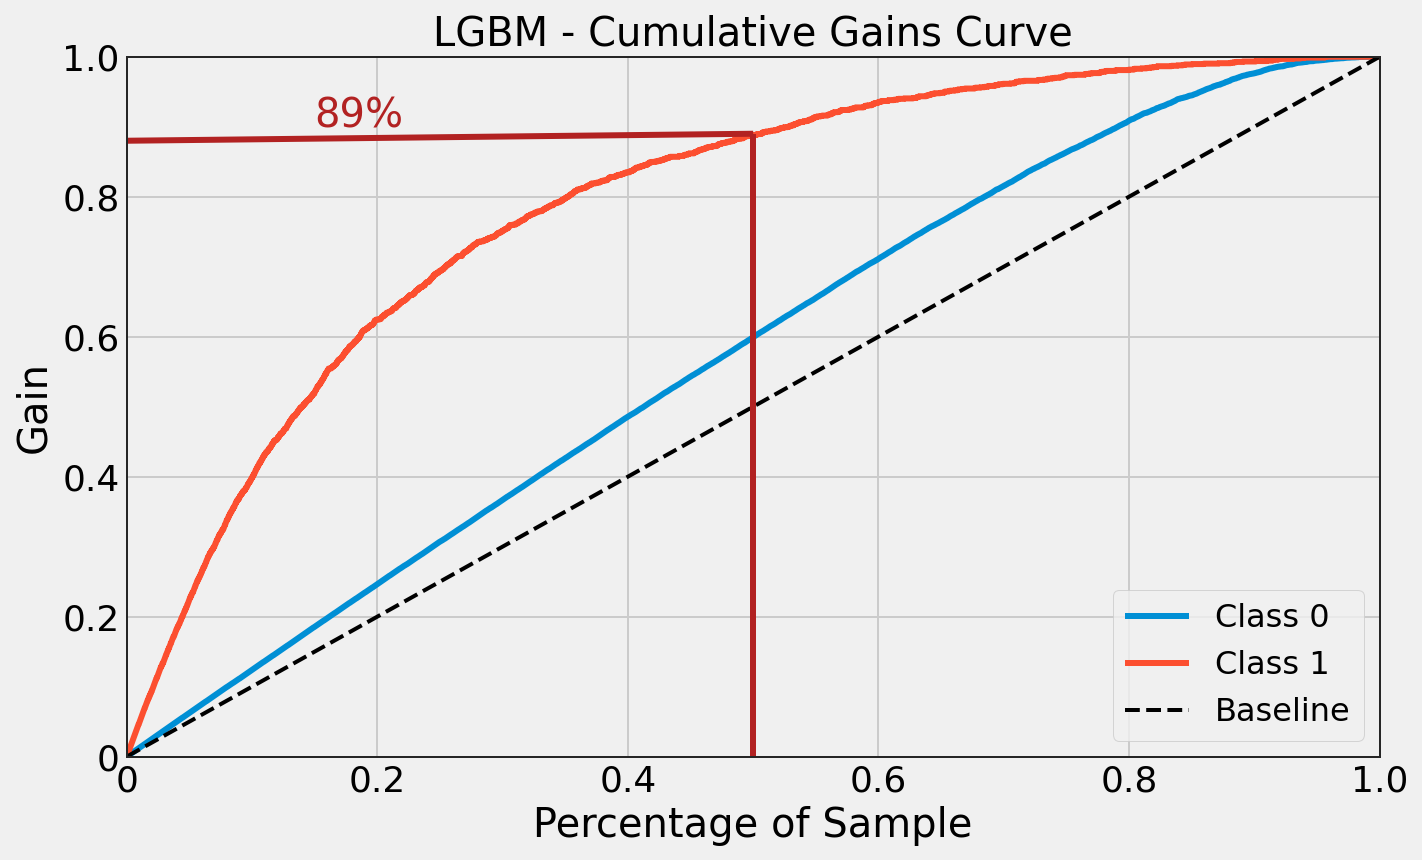

In [50]:
y_pred = cross_val_predict(best_lgbm_clf,
                           X_train,
                           y_train,
                           cv=cv,
                           method='predict_proba')

fig, ax = plt.subplots(figsize=(10, 6))

skplt.metrics.plot_cumulative_gain(y_train, y_pred, ax=ax)

ax.plot([0.5, 0.5], [0, 0.89], color='firebrick', lw=3)
ax.plot([0.0, 0.5], [0.88, 0.89], color='firebrick', lw=3)

ax.set_title('LGBM - Cumulative Gains Curve', size=font_size)
ax.set_xlabel('Percentage of Sample', size=font_size)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.set_ylabel('Gain', size=font_size)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.text(0.15, 0.90, '89%', size=font_size, color='firebrick')
ax.legend(fontsize=font_size - 4);

This chart shows that if we target 50% of the customers most likely to churn (according to the model), the model will pick 89% of customers who will actually churn, while the random pick would pick only 50% of the targets.

<br>

---

# Evaluating the Test Set

An integral part of any ML project is testing our models on unseen data. For this purpose, we will use the AUC score and compare the training and test set performance for all tuned models. 

In [51]:
train_auc_dict = {}
for key, value in comparison_dict.items():
    train_auc_dict[str(key)] = value[2]

test_auc_dict = {}
for i, (name, clf) in enumerate(
        zip(['LR', 'SVC', 'RF', 'BRF', 'GBC', 'XGB', 'LGBM', 'SVot'], [
            best_lr_clf.best_estimator_, best_svc_clf.best_estimator_,
            best_rf_clf.best_estimator_, best_brf_clf.best_estimator_,
            best_gbc_clf.best_estimator_, best_xgb_clf.best_estimator_,
            best_lgbm_clf.best_estimator_,
            tuned_voting_soft.fit(X_train, y_train)
        ])):

    y_pred = clf.predict_proba(X_test)[:, 1]
    test_auc_dict[name] = roc_auc_score(y_test, y_pred)

auc_comparison_df = pd.merge(pd.Series(train_auc_dict, name='AUC-Train'),
                             pd.Series(test_auc_dict, name='AUC-Test'),
                             left_index=True,
                             right_index=True)

auc_comparison_df['Diff. %'] = 100 * (
    auc_comparison_df['AUC-Train'] - auc_comparison_df['AUC-Test']) / auc_comparison_df['AUC-Train']
auc_comparison_df

,AUC-Train,AUC-Test,Diff. %
LR,0.772,0.767,0.657
SVC,0.860,0.850,1.194
RF,0.853,0.843,1.192
BRF,0.852,0.843,1.042
GBC,0.859,0.847,1.330
XGB,0.856,0.855,0.116
LGBM,0.865,0.858,0.829
SVot,0.859,0.852,0.850


The performance on the test set for all models is fairly similar to the training set, which proves that we **do not overfit the training set**. Therefore, we can predict customer churn with an AUC approximately equal to **86%**.

<br>

---

# Calculating Profit

We assume that the bank intends to invest £1,000 in services and offers for each customer likely to churn. If the customer remains, the bank expects a return approximately five times the initial investment, hence £5,000. We can write a function that calculates the total profit for our predictions (Ref. [[7](#References)]).

In [52]:
def calculate_profit(y_true, y_pred, **kwargs):
    tp = np.where((y_pred == 1) & (y_true == 1), (5000 - 1000), 0)
    fp = np.where((y_pred == 1) & (y_true == 0), -1000, 0)

    return np.sum([tp, fp])


profit = make_scorer(calculate_profit, greater_is_better=True)

In [53]:
estimators = [('GNB', GaussianNB().fit(X_train, y_train)),
              ('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('BRF', best_brf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('LGBM', best_lgbm_clf.best_estimator_),
              ('Ensemble', tuned_voting_soft.fit(X_train, y_train))]

profit_test = []
for estimator in estimators:

    y_pred = estimator[1].predict(X_test)
    profit_test.append(calculate_profit(y_test, y_pred))

profit_df = pd.DataFrame(data={'Profit-Test': profit_test},
                         index=[est[0] for est in estimators])

profit_df.style.highlight_max(color='indianred', axis=0)

,Profit-Test
GNB,456000
LR,677000
SCV,882000
RF,830000
BRF,826000
GBC,530000
XGB,890000
LGBM,900000
Ensemble,848000


The **LGBM classifier**, the classifier with the highest AUC score, yields the **highest profit, around £900,000**! This amount is **almost double** the profit we would get with the baseline Gaussian Naive Bayes classifier.

<br>

---


# References

The main resources I used are the following two books:

**[1] [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), by Aurélien Géron (2019)**

**[2] [Practical Statistics for Data Scientists, 2nd Edition](https://www.oreilly.com/library/view/practical-statistics-for/9781492072935/), by Peter Bruce, Andrew Bruce, and Peter Gedeck (2020)**

<br>

The following resources also helped me in my analysis:

[3] [Bank Customer Churn](https://rstudio-pubs-static.s3.amazonaws.com/565148_6e82a5c320f14869bf63e23bcf59ce9b.html), by Zicheng Shi (same dataset but analysis in R) (Accessed: 21 December 2020)

[4] [Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html) on [scikit-learn.org](https://scikit-learn.org/stable/modules/model_evaluation.html) (Accessed: 20 December 2020)

[5] [Easy Guide To Data Preprocessing In Python](https://www.kdnuggets.com/2020/07/easy-guide-data-preprocessing-python.html), by [Ahmad Anis](https://www.kdnuggets.com/author/ahmad-anis) (Accessed: 20 December 2020)

[6] [Meaningful Metrics: Cumulative Gains and Lyft Charts](https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14), by [Raffi Sahakyan](https://medium.com/@raffisahakyan) (Accessed: 20 December 2020)

[7] [Predict Customer Churn (the right way) using PyCaret](https://towardsdatascience.com/predict-customer-churn-the-right-way-using-pycaret-8ba6541608ac), by [Moez Ali](https://moez-62905.medium.com/) (Accessed: 08 December 2021)

[8] [Bagging and Random Forest for Imbalanced Classification](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/) by [Jason Brownlee](https://machinelearningmastery.com/about/) (Accessed: 06 December 2021)

[9] [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) by [Jason Brownlee](https://machinelearningmastery.com/about/) (Accessed: 12 December 2021)

<br>

If you would like to read more about customer churn:

[10] [Churn Rate](https://www.investopedia.com/terms/c/churnrate.asp), by [Jake Frankenfield](https://www.investopedia.com/contributors/82577/) on [Investopedia](https://www.investopedia.com/) (Accessed: 15 December 2020)

[11] [Customer attrition](https://en.wikipedia.org/wiki/Customer_attrition) on [Wikipedia](https://en.wikipedia.org/wiki/Main_Page) (Accessed: 15 December 2020)

[12] [A Survey on Churn Prediction Techniques in Communication Sector](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.278.4171&rep=rep1&type=pdf), by N.Kamalraj and A.Malathi (Accessed: 15 December 2020)

[13] [Customer Attrition](https://www.optimove.com/resources/learning-center/customer-attrition) on [optimove](https://www.optimove.com/resources/learning-center/customer-attrition) (Accessed: 15 December 2020)

<br>

# Conclusions

Our notebook just came to an end! Our final report to the bank should be based on two main points:

- **EDA** can help us identify which features contribute to customer churn. Additionally, **feature importance** analysis can quantify the importance of each feature in predicting the likelihood of churn. Our results reveal that the most significant feature is **age** (older customers are more likely to churn), followed by the **number of products** (having more products increases a customer’s likelihood to churn). The bank could use our findings to adapt and improve its services to increase satisfaction for those customers more likely to churn.

<br>

- We can build several **ML models** using the pre-processed dataset. The best-performing model with an **AUC score of ~0.865** is the optimised model based on the **LGBM classifier**. The model was tested on unseen data. For a test set consisting of 2,000 customers, this model yields a **total profit of £900,000**! As a comparison, our baseline model (based on the Gaussian Naïve Bayes algorithm) produces a total profit of £456,000.

<br>